In [2]:

## mounting drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
!pip install -q transformers
!pip install -q datasets
!pip install -q tokenizers
!pip install -q torch
!pip install -q sacrebleu
!pip install -q rouge_score
!pip install evaluate
!pip install tabulate


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 491.2/491.2 kB 10.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 11.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 183.9/183.9 kB 15.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.5/143.5 kB 12.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.8/194.8 kB 16.7 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torch 2.6.0+cu124 requires nvidia-cublas-cu12==12.4.5.8; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cublas-cu12 12.5.3.2 which is incompatible.
torch 2.6.0+cu124 requires nvidia-cuda-cupti-cu12==12.4.127; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cuda-cupti-cu12 12.5.82 which is incompatible.
torch 2.6.0+cu124 requires nvidia-cuda-nvrtc-cu12

# Data Preprocessing

### step 1: Structuring dataset
-  structured, chunked QA format where each chunk is paired with a prompt. Each instance is already tagged with whether it contains an answer (flag = answer_present) or not (flag = answer_not_present), which is used for chunk classification layer and combined fusion

In [ ]:
import json
import multiprocessing
from transformers import AutoTokenizer
from collections import defaultdict

tokenizer = AutoTokenizer.from_pretrained("facebook/bart-base")
MAX_TOKENS = 512
OVERLAP = 256
# Chunking Function
def split_text_into_chunks(text, max_tokens, tokenizer, prompt_length, overlap=256):
    """
    Splits text into overlapping chunks while maintaining clause integrity.
    Uses a sliding window approach with a specified overlap size.
    """
    # Adjust the max_tokens to account for the prompt length
    max_tokens -= prompt_length
    words = text.split()
    chunks = []
    start = 0

    while start < len(words):
        # Form a chunk from the current window
        chunk_words = words[start:start + max_tokens]
        chunk_text = " ".join(chunk_words)

        # Tokenize and ensure chunk length is within limits
        tokenized = tokenizer(chunk_text, add_special_tokens=False, truncation=True, max_length=max_tokens)
        tokenized_chunk = tokenized["input_ids"]
        truncated_text = tokenizer.decode(tokenized_chunk, skip_special_tokens=True)

        # Try to end the chunk at a sentence boundary if possible
        if len(truncated_text) < max_tokens and "." in truncated_text:
            end = truncated_text.rfind(".") + 1
            if end > 0:
                truncated_text = truncated_text[:end]

        chunks.append(truncated_text)
        # Move the start pointer forward by max_tokens minus overlap (sliding window)
        start += max_tokens - overlap

    return chunks

#last chunk
def restructure_dataset_for_qa(contract, doc_id, tokenizer, max_tokens=512, overlap=256):
    """
    Restructures a contract into question-chunk pairs using a sliding window and includes metadata.
    Filters out QA pairs where the answer is not present.
    """
    contract_title = contract["title"]
    paragraphs = contract["paragraphs"]
    processed_data = []

    # Combine all paragraph texts into a single cleaned context
    full_text = " ".join([para["context"] for para in paragraphs])

    for paragraph in paragraphs:
        for qa in paragraph["qas"]:
            if qa["is_impossible"]:
                continue
            clause_type = qa["question"].split("related to \"")[1].split("\"")[0] if "related to \"" in qa["question"] else "General"
            question_text = qa["question"]
            if "Details:" in question_text:
                question_text = question_text.split("Details:")[0].strip()
            expected_answers = [ans["text"] for ans in qa["answers"]]

            # Create the input prompt
            input_prompt = (
                f"Extract {clause_type} from the provided text. "
                f"Only extract the exact clause without adding or removing words.\n"
                f"QUESTION: {question_text}\n"
                f"CONTEXT: "
            ) #f"2. If the {clause_type} is missing or not explicitly present, return 'No Answer'.\n"

            # Get the length of the prompt in tokens
            prompt_length = len(tokenizer.encode(input_prompt, add_special_tokens=False))

            # Generate chunks with the adjusted max length
            chunks = split_text_into_chunks(full_text, max_tokens, tokenizer, prompt_length, overlap)

            # Iterate through each chunk to pair it with the question and metadata
            for chunk in chunks:
                answer_presence = any(answer in chunk for answer in expected_answers)
                flag = "answer_present" if answer_presence else "answer_not_present"
                input_text = input_prompt + chunk

                processed_data.append({
                    "doc_id": doc_id,
                    "contract_title": contract_title,
                    "clause_type": clause_type,
                    "question": question_text,
                    "input": input_text ,
                    "expected_output": expected_answers if answer_presence else ["No answer"],
                    "flag": flag
                })

    return processed_data

# Processing All Contracts
def process_all_contracts(dataset, tokenizer):
    """
    Apply chunking and restructuring to all contracts in the dataset.
    """
    data_with_ids = [(contract, idx) for idx, contract in enumerate(dataset)]

    with multiprocessing.Pool(processes=8) as pool:
        # Use restructure_dataset_for_qa directly instead of a lambda
        chunked_results = pool.starmap(
            restructure_dataset_for_qa,  # Pass the function directly
            [(contract, doc_id, tokenizer) for contract, doc_id in data_with_ids]
        )

    # Flatten the list of results
    restructured_dataset = [sample for sublist in chunked_results for sample in sublist]
    return restructured_dataset

# Load the CUAD dataset
with open('/content/drive/My Drive/Colab Notebooks/NLP_266_Project/Data/CUAD_v1.json', 'r', encoding='utf-8') as file:
    raw_data = json.load(file)["data"]

# Apply chunking and restructuring
chunked_dataset = process_all_contracts(raw_data, tokenizer)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/1.72k [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

In [ ]:
chunked_dataset[:5]

[{'doc_id': 0,
  'contract_title': 'LIMEENERGYCO_09_09_1999-EX-10-DISTRIBUTOR AGREEMENT',
  'clause_type': 'Document Name',
  'question': 'Highlight the parts (if any) of this contract related to "Document Name" that should be reviewed by a lawyer.',
  'input': 'You are a legal document analyst specializing in contract clause identification. Your task is to accurately extract the Document Name from the provided text. 1. Only extract the exact clause without adding or removing words.\nQUESTION: Highlight the parts (if any) of this contract related to "Document Name" that should be reviewed by a lawyer.\nCONTEXT: EXHIBIT 10.6 DISTRIBUTOR AGREEMENT THIS DISTRIBUTOR AGREEMENT (the "Agreement") is made by and between Electric City Corp., a Delaware corporation ("Company") and Electric City of Illinois LLC ("Distributor") this 7th day of September, 1999. RECITALS A. The Company\'s Business. The Company is presently engaged in the business of selling an energy efficiency device, which is refe

In [ ]:
import random

def undersample_no_answer_chunks(dataset, no_answer_label="no answer", target_ratio=0.40, seed=42):
    """
    Returns a filtered version of the dataset where 'no answer' chunks are undersampled
    to the desired ratio relative to the total dataset size.

    Args:
        dataset: list of dicts (chunked_dataset)
        no_answer_label (str): the consistent label used for 'no answer' chunks
        target_ratio (float): the proportion of 'no answer' chunks in the final dataset
        seed (int): for reproducible random sampling

    Returns:
        list of filtered dicts
    """
    random.seed(seed)

    # Separate chunks
    no_answer_chunks = [chunk for chunk in dataset if chunk['flag'] == "answer_not_present"]
    answer_chunks = [chunk for chunk in dataset if chunk['flag'] == "answer_present"]

    # Calculate how many 'no answer' chunks to retain
    target_no_answer_count = int((len(answer_chunks) / (1 - target_ratio)) * target_ratio)

    # Randomly sample 'no answer' chunks
    sampled_no_answer_chunks = random.sample(no_answer_chunks, min(target_no_answer_count, len(no_answer_chunks)))

    # Combine and shuffle
    final_dataset = answer_chunks + sampled_no_answer_chunks
    random.shuffle(final_dataset)

    return final_dataset
chunked_dataset_filtered = undersample_no_answer_chunks(chunked_dataset)
print(f"Filtered dataset size: {len(chunked_dataset_filtered)}")


Filtered dataset size: 49276


In [ ]:
import datasets
from datasets import Dataset, DatasetDict

# Convert to Hugging Face Dataset format
hf_dataset = Dataset.from_list(chunked_dataset_filtered)

# Split into train (80%), validation (10%), and test (10%)
train_test_split = hf_dataset.train_test_split(test_size=0.2, seed=42)
valid_test_split = train_test_split["test"].train_test_split(test_size=0.5, seed=42)

# Correctly label the dataset splits
bart_dataset = DatasetDict({
    "train": train_test_split["train"],
    "validation": valid_test_split["train"],  # Corrected label
    "test": valid_test_split["test"]  # Corrected label
})

In [ ]:
bart_dataset

DatasetDict({
    train: Dataset({
        features: ['doc_id', 'contract_title', 'clause_type', 'question', 'input', 'expected_output', 'flag'],
        num_rows: 39420
    })
    validation: Dataset({
        features: ['doc_id', 'contract_title', 'clause_type', 'question', 'input', 'expected_output', 'flag'],
        num_rows: 4928
    })
    test: Dataset({
        features: ['doc_id', 'contract_title', 'clause_type', 'question', 'input', 'expected_output', 'flag'],
        num_rows: 4928
    })
})

In [ ]:
#save bart to disk
bart_dataset.save_to_disk("/content/drive/My Drive/Colab Notebooks/NLP_266_Project/bart_dataset")

In [ ]:
from transformers import AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained("facebook/bart-base")
MAX_INPUT_LENGTH = 512
MAX_OUTPUT_LENGTH = 256

def tokenize_bart_example(example):
    input_text = example["input"]
    target_text = "\n".join(example["expected_output"]).strip()

    # Tokenize input
    model_input = tokenizer(
        input_text,
        max_length=MAX_INPUT_LENGTH,
        padding="max_length",
        truncation=True,
        return_tensors="pt"
    )

    # Tokenize target
    with tokenizer.as_target_tokenizer():
        labels = tokenizer(
            target_text,
            max_length=MAX_OUTPUT_LENGTH,
            padding="max_length",
            truncation=True,
            return_tensors="pt"
        )

    return {
        "input_ids": model_input["input_ids"].squeeze(),
        "attention_mask": model_input["attention_mask"].squeeze(),
        "labels": labels["input_ids"].squeeze(),
        "flag": 1 if example["flag"] == "answer_present" else 0,
        "doc_id": example["doc_id"],
    }
tokenized_bart_dataset = bart_dataset.map(
    tokenize_bart_example,
    batched=False,
    remove_columns=["input","contract_title","question", "clause_type","expected_output" ]  # ⛔ Don’t remove metadata columns
)

tokenized_bart_dataset.set_format(type="torch")


Map:   0%|          | 0/39420 [00:00<?, ? examples/s]

/usr/local/lib/python3.11/dist-packages/transformers/tokenization_utils_base.py:3980: UserWarning: `as_target_tokenizer` is deprecated and will be removed in v5 of Transformers. You can tokenize your labels by using the argument `text_target` of the regular `__call__` method (either in the same call as your input texts if you use the same keyword arguments, or in a separate call.
  warnings.warn(


Map:   0%|          | 0/4928 [00:00<?, ? examples/s]

Map:   0%|          | 0/4928 [00:00<?, ? examples/s]

In [ ]:
tokenized_bart_dataset

DatasetDict({
    train: Dataset({
        features: ['doc_id', 'input', 'expected_output', 'flag', 'input_ids', 'attention_mask', 'labels'],
        num_rows: 39420
    })
    validation: Dataset({
        features: ['doc_id', 'input', 'expected_output', 'flag', 'input_ids', 'attention_mask', 'labels'],
        num_rows: 4928
    })
    test: Dataset({
        features: ['doc_id', 'input', 'expected_output', 'flag', 'input_ids', 'attention_mask', 'labels'],
        num_rows: 4928
    })
})

### adding chunk index and counts to filtered dataset

In [ ]:
import json
#reload filtered dataset
with open("/content/drive/My Drive/Colab Notebooks/NLP_266_Project/Data/bart_chunked_dataset_filtered.json", "r") as f:
    chunked_dataset_filtered = json.load(f)

In [ ]:
#save tokenized dataset to disk
tokenized_bart_dataset.save_to_disk("/content/drive/My Drive/Colab Notebooks/NLP_266_Project/tokenized_datasets/tokenized_bart_dataset")

#### adding chunk count

In [ ]:
# Sort dataset by doc_id (and optionally by original chunk order if available)
sorted_data = sorted(chunked_dataset_filtered, key=lambda x: (x['doc_id'], x.get('chunk_start', 0)))

#### 1.document in sorted order

In [ ]:
sorted_data[:3]

[{'doc_id': 0,
  'contract_title': 'LIMEENERGYCO_09_09_1999-EX-10-DISTRIBUTOR AGREEMENT',
  'clause_type': 'Parties',
  'question': 'Highlight the parts (if any) of this contract related to "Parties" that should be reviewed by a lawyer.',
  'input': 'You are a legal document analyst specializing in contract clause identification. Your task is to accurately extract the Parties from the provided text. 1. Only extract the exact clause without adding or removing words.\nQUESTION: Highlight the parts (if any) of this contract related to "Parties" that should be reviewed by a lawyer.\nCONTEXT: damages, losses and the like (including attorneys\' fees and costs) relating to or arising out of: (A) any breach of any material representations, warranties, covenants, obligations, agreements or duties in connection with this Agreement; (b) any negligence or fault; (c) any violation by either of them of the patent, copyright, trademark or other Page -10- intellectual property rights of third parties.

#### 2. sort dataset and add chunked index and counts per documents

In [ ]:
from collections import defaultdict
from datasets import Dataset

# Step 1: Count number of chunks per doc_id
doc_chunk_counts = defaultdict(int)
for example in chunked_dataset_filtered:
    doc_chunk_counts[example["doc_id"]] += 1

# Step 2: Assign chunk_counts and chunk_index
doc_chunk_indices = defaultdict(int)

updated_data = []
for example in chunked_dataset_filtered:
    doc_id = example["doc_id"]
    chunk_index = doc_chunk_indices[doc_id]
    chunked_example = {
        **example,
        "chunk_counts": doc_chunk_counts[doc_id],
        "chunk_index": chunk_index  # starts from 0; use +1 if you want 1-based
    }
    doc_chunk_indices[doc_id] += 1
    updated_data.append(chunked_example)




In [ ]:
# Sort by doc_id, then chunk_index (ascending) to examin dataset
sorted_data_update = sorted(updated_data, key=lambda x: (x['doc_id'], x['chunk_index']))

In [ ]:
len(sorted_data_update)

49276

In [ ]:
import datasets
from datasets import Dataset, DatasetDict

# Convert to Hugging Face Dataset format
hf_dataset = Dataset.from_list(sorted_data_update)

# Split into train (80%), validation (10%), and test (10%)
train_test_split = hf_dataset.train_test_split(test_size=0.2, seed=42)
valid_test_split = train_test_split["test"].train_test_split(test_size=0.5, seed=42)

# Correctly label the dataset splits
bart_dataset_sorted = DatasetDict({
    "train": train_test_split["train"],
    "validation": valid_test_split["train"],  # Corrected label
    "test": valid_test_split["test"]  # Corrected label
})

In [ ]:
# save bart_dataset_sorted as hf model
bart_dataset_sorted.save_to_disk("/content/drive/My Drive/Colab Notebooks/NLP_266_Project/Data/bart_dataset_sorted")

Saving the dataset (0/1 shards):   0%|          | 0/39420 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/4928 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/4928 [00:00<?, ? examples/s]

In [ ]:
bart_dataset_sorted

DatasetDict({
    train: Dataset({
        features: ['doc_id', 'contract_title', 'clause_type', 'question', 'input', 'expected_output', 'flag', 'chunk_counts', 'chunk_index'],
        num_rows: 39420
    })
    validation: Dataset({
        features: ['doc_id', 'contract_title', 'clause_type', 'question', 'input', 'expected_output', 'flag', 'chunk_counts', 'chunk_index'],
        num_rows: 4928
    })
    test: Dataset({
        features: ['doc_id', 'contract_title', 'clause_type', 'question', 'input', 'expected_output', 'flag', 'chunk_counts', 'chunk_index'],
        num_rows: 4928
    })
})

for bart tokenized no indices

tokenizing bart dataset sorted with chunk id

In [ ]:
from transformers import AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained("facebook/bart-base")
MAX_INPUT_LENGTH = 512
MAX_OUTPUT_LENGTH = 256

def tokenize_bart_example(example):
    input_text = example["input"]
    target_text = "\n".join(example["expected_output"]).strip()

    # Tokenize input
    model_input = tokenizer(
        input_text,
        max_length=MAX_INPUT_LENGTH,
        padding="max_length",
        truncation=True,
        return_tensors="pt"
    )

    # Tokenize target
    with tokenizer.as_target_tokenizer():
        labels = tokenizer(
            target_text,
            max_length=MAX_OUTPUT_LENGTH,
            padding="max_length",
            truncation=True,
            return_tensors="pt"
        )

    return {
        "input_ids": model_input["input_ids"].squeeze(),
        "attention_mask": model_input["attention_mask"].squeeze(),
        "labels": labels["input_ids"].squeeze(),
        "flag": 1 if example["flag"] == "answer_present" else 0,
        "doc_id": example["doc_id"],
        "chunk_counts": example["chunk_counts"],
        "chunk_index": example["chunk_index"],
        "question": example["question"],
        "clause_type": example["clause_type"]
    }
tokenized_bart_dataset_sorted = bart_dataset_sorted.map(
    tokenize_bart_example,
    batched=False,
    remove_columns=["input","contract_title","question", "clause_type","expected_output" ]  # Don’t remove metadata columns
)

tokenized_bart_dataset_sorted.set_format(type="torch")


Map:   0%|          | 0/39420 [00:00<?, ? examples/s]

/usr/local/lib/python3.11/dist-packages/transformers/tokenization_utils_base.py:3980: UserWarning: `as_target_tokenizer` is deprecated and will be removed in v5 of Transformers. You can tokenize your labels by using the argument `text_target` of the regular `__call__` method (either in the same call as your input texts if you use the same keyword arguments, or in a separate call.
  warnings.warn(


Map:   0%|          | 0/4928 [00:00<?, ? examples/s]

Map:   0%|          | 0/4928 [00:00<?, ? examples/s]

In [ ]:
tokenized_bart_dataset["train"][0]
# Should include: input_ids, attention_mask, labels, flag, doc_id, clause_type, question


{'doc_id': tensor(326),
 'flag': tensor(0),
 'input_ids': tensor([    0,  1185,    32,    10,  1030,  3780,  2066, 25526,    11,  1355,
         13166, 10614,     4,  2486,  3685,    16,     7, 12775, 14660,     5,
          9511,    12, 26039, 15645,    31,     5,  1286,  2788,     4,   112,
             4,  4041, 14660,     5,  6089, 13166,   396,  1271,    50,  8201,
          1617,     4, 50118, 46392,  7744,    35,   755,  6991,     5,  1667,
            36,  1594,   143,    43,     9,    42,  1355,  1330,     7,    22,
         40948,    12, 26039, 15645,   113,    14,   197,    28,  7123,    30,
            10,  2470,     4, 50118, 15299, 49347,    35,  1643,     6, 14999,
           255,  2571,    12,  1570,  2148,    30,   839,     9,    10, 20917,
         15739,     8,    11,  3328,     9,   143,     8,    70, 30665, 11150,
            13,     5,  6397,     9,   758, 15601,     4, 36759,  3764, 24199,
         32568, 13709,    83,  1355,     7,   146,  2148,   577,    31,   

#### last saved tokenized - 4/13/2025

In [ ]:
tokenized_bart_dataset_sorted.save_to_disk("/content/drive/My Drive/Colab Notebooks/NLP_266_Project/Data/tokenized_bart_dataset_sorted")

Saving the dataset (0/1 shards):   0%|          | 0/39420 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/4928 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/4928 [00:00<?, ? examples/s]

In [ ]:
#save chunked dataset
with open("/content/drive/My Drive/Colab Notebooks/NLP_266_Project/Data/bart_chunked_dataset.json", "w") as f:
    json.dump(chunked_dataset, f, indent=4)

#save filtered chunked dataset
with open("/content/drive/My Drive/Colab Notebooks/NLP_266_Project/Data/bart_chunked_dataset_filtered.json", "w") as f:
    json.dump(chunked_dataset_filtered, f, indent=4)

Saving the dataset (0/1 shards):   0%|          | 0/39420 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/4928 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/4928 [00:00<?, ? examples/s]

#### saved newly dataset with chunk index and count

In [ ]:
#saved tokenized sorted dataset
tokenized_bart_dataset_sorted.save_to_disk("/content/drive/My Drive/Colab Notebooks/NLP_266_Project/tokenized_datasets/tokenized_bart_dataset")

Saving the dataset (0/1 shards):   0%|          | 0/39420 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/4928 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/4928 [00:00<?, ? examples/s]

In [ ]:
save_path = "/content/drive/My Drive/Colab Notebooks/NLP_266_Project/Data/tokenized_bart_dataset_sorted"

# Try saving again
tokenized_bart_dataset_sorted.save_to_disk(save_path)


Saving the dataset (0/1 shards):   0%|          | 0/39420 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/4928 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/4928 [00:00<?, ? examples/s]

In [ ]:
tokenized_bart_dataset_sorted

DatasetDict({
    train: Dataset({
        features: ['doc_id', 'flag', 'chunk_counts', 'chunk_index', 'input_ids', 'attention_mask', 'labels'],
        num_rows: 39420
    })
    validation: Dataset({
        features: ['doc_id', 'flag', 'chunk_counts', 'chunk_index', 'input_ids', 'attention_mask', 'labels'],
        num_rows: 4928
    })
    test: Dataset({
        features: ['doc_id', 'flag', 'chunk_counts', 'chunk_index', 'input_ids', 'attention_mask', 'labels'],
        num_rows: 4928
    })
})

### Step 2: Preparing the Model Input + Dataset Object.
- 2.1 Tokenization Logic:
Prompt and chunk go into the BART encoder

The expected_output (usually a clause or "No answer") is the decoder target

 - BartForConditionalGeneration for clause generation (extractive QA)

- A classification head (self.classifier) for predicting if the chunk has an answer (flag)

- A joint loss combining generation + classification

- Flexibility to toggle training vs inference

first model - BART-based encoder-decoder with: A classification head on the [CLS]-equivalent for answer/no-answer flag. Standard per-chunk processing (each chunk treated independently)

In [ ]:
import datasets
#load tokenized bart
tokenized_bart_dataset = datasets.load_from_disk("/content/drive/My Drive/Colab Notebooks/NLP_266_Project/tokenized_datasets/tokenized_bart_dataset")

## Modeling


### Bart fusion Fusion-Based
Issue: Clauses span multiple chunks, but base encoder-decoder models see chunks independently.

In [4]:
import torch
import torch.nn as nn
from transformers import BartForConditionalGeneration
from transformers import AutoTokenizer

# Load tokenizer
tokenizer = AutoTokenizer.from_pretrained("facebook/bart-base")

class BartFusionChunkClassifier(nn.Module):
    def __init__(self, model_name="facebook/bart-base", hidden_size=768, fusion="lstm", dropout=0.1):
        super().__init__()
        self.bart = BartForConditionalGeneration.from_pretrained(model_name)

        # Cross-chunk fusion layer
        self.fusion_type = fusion
        if fusion == "lstm":
            self.fusion_layer = nn.LSTM(input_size=hidden_size, hidden_size=hidden_size, num_layers=1, bidirectional=True, batch_first=True)
            self.fusion_proj = nn.Linear(hidden_size * 2, hidden_size)
        elif fusion == "transformer":
            encoder_layer = nn.TransformerEncoderLayer(d_model=hidden_size, nhead=8)
            self.fusion_layer = nn.TransformerEncoder(encoder_layer, num_layers=1)
        else:
            self.fusion_layer = None

        # Binary classifier: is this chunk relevant?
        self.chunk_classifier = nn.Sequential(
            nn.Dropout(dropout),
            nn.Linear(hidden_size, 1)  # sigmoid on output
        )

    def forward(self, input_ids, attention_mask, labels=None, flag=None, decoder_input_ids=None): # Add decoder_input_ids
        # Encode
        encoder_outputs = self.bart.model.encoder(input_ids=input_ids, attention_mask=attention_mask)
        encoder_hidden_states = encoder_outputs.last_hidden_state  # [B, T, H]

        # Grab [CLS]-like vector (first token)
        cls_repr = encoder_hidden_states[:, 0, :]  # [B, H]

        # Optional: Fuse across batch dimension to simulate document
        if self.fusion_layer:
            # Reshape batch as sequence of chunks
            fused_input = cls_repr.unsqueeze(0)  # [1, B, H]
            if self.fusion_type == "lstm":
                lstm_out, _ = self.fusion_layer(fused_input)  # [1, B, 2H]
                cls_repr = self.fusion_proj(lstm_out.squeeze(0))  # [B, H]
            else:
                cls_repr = self.fusion_layer(fused_input).squeeze(0)  # [B, H]

        # Chunk classification
        chunk_logits = self.chunk_classifier(cls_repr).squeeze(-1)  # [B]

        # Decoder for generation
        # Pass decoder_input_ids to the Bart model
        model_output = self.bart(input_ids=input_ids, attention_mask=attention_mask, labels=labels, decoder_input_ids=decoder_input_ids, return_dict=True) # Pass decoder_input_ids here

        loss = model_output.loss
        result = {
            "loss": loss,
            "logits": model_output.logits,
            "chunk_logits": chunk_logits,
        }

        # Chunk classification loss
        if flag is not None:
            flag = flag.float()
            bce = nn.BCEWithLogitsLoss()
            cls_loss = bce(chunk_logits, flag)
            result["classification_loss"] = cls_loss
            # Check if loss is None before adding cls_loss
            if loss is not None:
                result["loss"] = loss + cls_loss  # Optionally weight this
            else:
                result["loss"] = cls_loss # If loss is None, use cls_loss as the total loss
        return result

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/1.72k [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

In [5]:
# Instantiate the model
model = BartFusionChunkClassifier(
    model_name="facebook/bart-base",
    hidden_size=768,             # BART base has hidden size 768
    fusion="lstm",
    dropout=0.1
)

model.safetensors:   0%|          | 0.00/558M [00:00<?, ?B/s]

In [ ]:
from transformers import DataCollatorForSeq2Seq

data_collator = DataCollatorForSeq2Seq(
    tokenizer=tokenizer,
    model=model.bart,
    padding="longest",
    return_tensors="pt"
)


In [ ]:
from transformers import Seq2SeqTrainingArguments
output_dir="/content/drive/My Drive/Colab Notebooks/NLP_266_Project/checkpoints"

training_args = Seq2SeqTrainingArguments(
    output_dir=output_dir,
    evaluation_strategy="epoch",
    save_strategy="epoch",
    logging_dir="./logs",
    logging_steps=500,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    num_train_epochs=5,
    learning_rate=5e-5,
    weight_decay=0.01,
    max_grad_norm=1.0,
    warmup_steps=500,
    gradient_accumulation_steps=1,
    report_to="none",
    label_smoothing_factor=0.1,
    predict_with_generate=False,
    save_safetensors=False,
    fp16=True,
    save_total_limit=2
)


/usr/local/lib/python3.11/dist-packages/transformers/training_args.py:1611: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


### Training

In [ ]:
from transformers import Seq2SeqTrainer

trainer = Seq2SeqTrainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_bart_dataset_sorted["train"],
    eval_dataset=tokenized_bart_dataset_sorted["validation"],
    tokenizer=tokenizer,
    data_collator=data_collator

)
trainer.train()

<ipython-input-27-036d2662033d>:3: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Seq2SeqTrainer.__init__`. Use `processing_class` instead.
  trainer = Seq2SeqTrainer(


Epoch,Training Loss,Validation Loss
1,1.484200,1.497345
2,1.480500,1.481476
3,1.464200,1.470870
4,1.453300,1.466923
5,1.445500,1.464303


TrainOutput(global_step=24640, training_loss=1.4708246726494332, metrics={'train_runtime': 2068.7619, 'train_samples_per_second': 95.274, 'train_steps_per_second': 11.911, 'total_flos': 0.0, 'train_loss': 1.4708246726494332, 'epoch': 5.0})

In [ ]:
metrics = trainer.evaluate()
print(metrics)

{'eval_loss': 1.4643030166625977, 'eval_runtime': 18.6752, 'eval_samples_per_second': 263.879, 'eval_steps_per_second': 32.985, 'epoch': 5.0}


In [ ]:
bart_model_checkpoint_filepath = "/content/drive/My Drive/Colab Notebooks/NLP_266_Project/model_checkpoints"

# Save model state
torch.save(model.state_dict(), f"{bart_model_checkpoint_filepath}/bart_fusion_model.pt")


In [ ]:
#Saving the Model Configuration
bart_fusion_config = {
    "model_name": "facebook/bart-base",
    "hidden_size": 768,
    "fusion": "lstm",
    "dropout": 0.1
}

import json
with open(f"{bart_model_checkpoint_filepath}/bart_fusion_config.json", "w") as f:
    json.dump(bart_fusion_config, f)


In [22]:
import json
bart_model_checkpoint_filepath = "/content/drive/My Drive/Colab Notebooks/NLP_266_Project/model_checkpoints"
# Load config
with open(f"{bart_model_checkpoint_filepath}/bart_fusion_config.json") as f:
    config = json.load(f)

# Rebuild model with saved config
model = BartFusionChunkClassifier(
    model_name=config["model_name"],
    hidden_size=config["hidden_size"],
    fusion=config["fusion"],
    dropout=config["dropout"]
)

# Load weights
model.load_state_dict(torch.load(f"{bart_model_checkpoint_filepath}/bart_fusion_model.pt"))
model.to("cuda" if torch.cuda.is_available() else "cpu")
model.eval()


BartFusionChunkClassifier(
  (bart): BartForConditionalGeneration(
    (model): BartModel(
      (shared): BartScaledWordEmbedding(50265, 768, padding_idx=1)
      (encoder): BartEncoder(
        (embed_tokens): BartScaledWordEmbedding(50265, 768, padding_idx=1)
        (embed_positions): BartLearnedPositionalEmbedding(1026, 768)
        (layers): ModuleList(
          (0-5): 6 x BartEncoderLayer(
            (self_attn): BartSdpaAttention(
              (k_proj): Linear(in_features=768, out_features=768, bias=True)
              (v_proj): Linear(in_features=768, out_features=768, bias=True)
              (q_proj): Linear(in_features=768, out_features=768, bias=True)
              (out_proj): Linear(in_features=768, out_features=768, bias=True)
            )
            (self_attn_layer_norm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
            (activation_fn): GELUActivation()
            (fc1): Linear(in_features=768, out_features=3072, bias=True)
            (fc2): Lin

## Evaluation on Validation Dataset

### Evaluate Classification (Chunk Relevance)

In [ ]:
!pip install tqdm
from tqdm import tqdm
import torch
from transformers import AutoTokenizer
import datasets

dataset = tokenized_bart_dataset_sorted["validation"]

# Define batch_size
batch_size = 16


model.eval()
preds, labels = [], []

with torch.no_grad():
    for i in tqdm(range(0, len(dataset), batch_size)):
        batch = dataset.select(range(i, min(i + batch_size, len(dataset))))

        input_ids = batch["input_ids"].to("cuda") # removing torch.stack and directly moving to cuda
        attention_mask = batch["attention_mask"].to("cuda") # removing torch.stack and directly moving to cuda
        flags = torch.tensor(batch["flag"]).float().to("cuda")

        outputs = model(input_ids=input_ids, attention_mask=attention_mask, flag=flags)

        chunk_logits = outputs["chunk_logits"]
        preds.extend((chunk_logits > 0).int().tolist())
        labels.extend(flags.int().tolist())

# ... (Rest of your evaluation code) ...

  0%|          | 0/308 [00:00<?, ?it/s]<ipython-input-37-50aebc6987f5>:24: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  flags = torch.tensor(batch["flag"]).float().to("cuda")
100%|██████████| 308/308 [00:14<00:00, 21.64it/s]


In [ ]:
from sklearn.metrics import classification_report

print(classification_report(labels, preds, target_names=["Not Relevant", "Relevant"]))

              precision    recall  f1-score   support

Not Relevant       0.40      1.00      0.57      1974
    Relevant       0.00      0.00      0.00      2954

    accuracy                           0.40      4928
   macro avg       0.20      0.50      0.29      4928
weighted avg       0.16      0.40      0.23      4928



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


### Inspecting  classification Predictions

In [ ]:
def inspect_predictions(model, dataset, tokenizer, batch_size=16, device="cuda",
                        show_correct=False, show_incorrect=False, show_all=False, max_examples=20):
    """
    Evaluate the model on the dataset and display predictions vs. ground truth (decoded).
    Supports viewing correct, incorrect, or all predictions.
    """
    model.eval()
    preds, labels = [], []
    decoded_inputs, decoded_labels = [], []

    with torch.no_grad():
        for i in range(0, len(dataset), batch_size):
            batch = dataset.select(range(i, min(i + batch_size, len(dataset))))

            # Removing torch.stack as the data is already in tensor format
            input_ids = batch["input_ids"].to(device)
            attention_mask = batch["attention_mask"].to(device)
            flags = torch.tensor(batch["flag"]).float().to(device)
            label_ids = batch["labels"].to(device)

            outputs = model(input_ids=input_ids, attention_mask=attention_mask, flag=flags)
            chunk_logits = outputs["chunk_logits"]
            pred_classes = (chunk_logits > 0).int().tolist()
            true_classes = flags.int().tolist()

            preds.extend(pred_classes)
            labels.extend(true_classes)

            # Decode input text and labels
            decoded_inputs.extend(tokenizer.batch_decode(input_ids, skip_special_tokens=True))
            decoded_labels.extend(tokenizer.batch_decode(label_ids, skip_special_tokens=True))

    print("\n Inspecting predictions:\n")

    shown = 0
    for i in range(len(preds)):
        correct = preds[i] == labels[i]

        if show_all or (show_correct and correct) or (show_incorrect and not correct):
            print(f"\n Example {i + 1}")
            print(f"Input Text:\n{decoded_inputs[i][:400]}...")
            print(f"Extracted Answer (Label): {decoded_labels[i]}")
            print(f"True Label: {labels[i]} |  Prediction: {preds[i]} {'Passed' if correct else '❌'}")
            print("-" * 80)

            shown += 1
            if shown >= max_examples:
                break
inspect_predictions(model, tokenized_bart_dataset_sorted["validation"], tokenizer, show_correct=True)

In [ ]:
inspect_predictions(model, tokenized_bart_dataset_sorted["validation"], tokenizer, show_correct=True)

<ipython-input-119-e4677a335c73>:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  flags = torch.tensor(batch["flag"]).float().to(device)



 Inspecting predictions:


 Example 5
Input Text:
You are a legal document analyst specializing in contract clause identification. Your task is to accurately extract the Post-Termination Services from the provided text. 1. Only extract the exact clause without adding or removing words.
QUESTION: Highlight the parts (if any) of this contract related to "Post-Termination Services" that should be reviewed by a lawyer.
CONTEXT: liability to Distribut...
Extracted Answer (Label): No answer
True Label: 0 |  Prediction: 0 Passed
--------------------------------------------------------------------------------

 Example 9
Input Text:
You are a legal document analyst specializing in contract clause identification. Your task is to accurately extract the Document Name from the provided text. 1. Only extract the exact clause without adding or removing words.
QUESTION: Highlight the parts (if any) of this contract related to "Document Name" that should be reviewed by a lawyer.
CONTEXT: any sum whic

### Function 2: analyze_errors()
Prints class-wise performance and optional hallucinations (false positives)

In [ ]:
def analyze_errors(model, dataset, tokenizer, batch_size=16, device="cuda", print_report=True, return_data=False):
    """
    Run evaluation on a dataset, print classification report, and return incorrect predictions.
    """
    model.eval()
    preds, labels, texts, doc_ids = [], [], [], []

    with torch.no_grad():
        for i in range(0, len(dataset), batch_size):
            batch = dataset.select(range(i, min(i + batch_size, len(dataset))))

            # Removing torch.stack and directly moving to cuda
            input_ids = batch["input_ids"].to(device)
            attention_mask = batch["attention_mask"].to(device)
            flags = torch.tensor(batch["flag"]).float().to(device)

            outputs = model(input_ids=input_ids, attention_mask=attention_mask, flag=flags)
            chunk_logits = outputs["chunk_logits"]
            pred_classes = (chunk_logits > 0).int().tolist()
            true_classes = flags.int().tolist()

            preds.extend(pred_classes)
            labels.extend(true_classes)
            texts.extend(batch["input_ids"])
            doc_ids.extend(batch["doc_id"])

    if print_report:
        print("\n Classification Report:")
        print(classification_report(labels, preds, target_names=["Not Relevant", "Relevant"]))

    errors = []
    for i in range(len(preds)):
        if preds[i] != labels[i]:
            errors.append({
                "doc_id": doc_ids[i],
                "prediction": preds[i],
                "label": labels[i],
                "text": texts[i],
                'text': texts[i],
                 'question': dataset[i]["question"],  # Add metadata
                 'clause_type': dataset[i]["clause_type"] # Add metadata'
            })

    if return_data:
        return errors

In [ ]:
errors = analyze_errors(model, tokenized_bart_dataset_sorted["validation"], tokenizer, return_data=True)

# Group errors by clause type
errors_by_clause_type = defaultdict(list)
for error in errors:
    errors_by_clause_type[error["clause_type"]].append(error)

# Print statistics for each clause type
for clause_type, errors in errors_by_clause_type.items():
    print(f"Clause Type: {clause_type}")
    print(f"Number of Errors: {len(errors)}")
    print("-" * 80)  # Separator

<ipython-input-105-5c30d3a29420>:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  flags = torch.tensor(batch["flag"]).float().to(device)



 Classification Report:
              precision    recall  f1-score   support

Not Relevant       0.40      1.00      0.57      1974
    Relevant       0.00      0.00      0.00      2954

    accuracy                           0.40      4928
   macro avg       0.20      0.50      0.29      4928
weighted avg       0.16      0.40      0.23      4928



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Clause Type: Post-Termination Services
Number of Errors: 39
--------------------------------------------------------------------------------
Clause Type: Parties
Number of Errors: 1757
--------------------------------------------------------------------------------
Clause Type: Agreement Date
Number of Errors: 107
--------------------------------------------------------------------------------
Clause Type: Non-Disparagement
Number of Errors: 12
--------------------------------------------------------------------------------
Clause Type: Liquidated Damages
Number of Errors: 16
--------------------------------------------------------------------------------
Clause Type: Volume Restriction
Number of Errors: 17
--------------------------------------------------------------------------------
Clause Type: Exclusivity
Number of Errors: 38
--------------------------------------------------------------------------------
Clause Type: Expiration Date
Number of Errors: 60
-------------------------

#### Evaluate generation output

In [ ]:
def evaluate_generation_outputs(
    model,
    dataset,
    tokenizer,
    batch_size=8,
    device="cuda",
    show_only_incorrect=False
):
    """
    Evaluates model on the entire dataset, comparing generated predictions to references.
    Returns a list of dictionaries with predictions, references, and metadata.
    """
    model.eval()
    results = []

    with torch.no_grad():
        for i in range(0, len(dataset), batch_size):
            batch = dataset.select(range(i, min(i + batch_size, len(dataset))))

            input_ids = batch["input_ids"].to(device)
            attention_mask = batch["attention_mask"].to(device)
            label_ids = batch["labels"].to(device)
            flags = torch.tensor(batch["flag"]).float().to(device)

            outputs = model(input_ids=input_ids, attention_mask=attention_mask, flag=flags)

            generated_ids = model.bart.generate(input_ids=input_ids, attention_mask=attention_mask)

            decoded_inputs = tokenizer.batch_decode(input_ids, skip_special_tokens=True)
            decoded_preds = tokenizer.batch_decode(generated_ids, skip_special_tokens=True)
            decoded_labels = tokenizer.batch_decode(label_ids, skip_special_tokens=True)

            for j in range(len(decoded_preds)):
                correct = decoded_preds[j].strip() == decoded_labels[j].strip()

                if show_only_incorrect and correct:
                    continue

                results.append({
                    "doc_id": batch["doc_id"][j],
                    "question": batch["question"][j],
                    "clause_type": batch["clause_type"][j],
                    "input_text": decoded_inputs[j],
                    "reference": decoded_labels[j].strip(),
                    "prediction": decoded_preds[j].strip(),
                    "correct": correct
                })

    return results

# Run on full validation set
val_results = evaluate_generation_outputs(model,tokenized_bart_dataset_sorted["validation"],tokenizer,batch_size=8,show_only_incorrect=False)

In [ ]:
# Run on full validation set
val_results = evaluate_generation_outputs(model,tokenized_bart_dataset_sorted["validation"],tokenizer,batch_size=8,show_only_incorrect=False)

# Access just incorrect predictions
val_missed = [r for r in val_results if not r["correct"]]


<ipython-input-92-bdf21ee27326>:23: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  flags = torch.tensor(batch["flag"]).float().to(device)


##### accessing only incorrect predictions

In [ ]:
#  incorrect predictions with clean formatting
for r in val_missed[:5]:
    print(" Doc ID:", r['doc_id'])
    print("Question:", r['question'])
    print("Reference:\n", r['reference'])
    print("Prediction:\n", r['prediction'])
    print("🟥 Incorrect" if not r['correct'] else "🟩 Correct")
    print("-" * 80)

 Doc ID: tensor(101)
Question: Highlight the parts (if any) of this contract related to "Post-Termination Services" that should be reviewed by a lawyer.
Reference:
 In the event of termination, the Distributor shall be entitled to receive all orders accepted by the Principal prior to the date of termination and may sell the ordered Products in the Territory.
Prediction:
 In the event of termination, the Distributor shall be entitled to receive all orders accepted by
🟥 Incorrect
--------------------------------------------------------------------------------
 Doc ID: tensor(341)
Question: Highlight the parts (if any) of this contract related to "Parties" that should be reviewed by a lawyer.
Reference:
 ("TELKOM")
TELKOM SOUTH AFRICA LIMITED
SYSTEMS APPLICATIONS PRODUCTS (AFRICA) (PTY) LIMITED
SAP AFRICA
Prediction:
 ("TELKOM SOUTH AFRICA LIMITED
SYSTEMS APPLICATIONS PRODUCT
🟥 Incorrect
--------------------------------------------------------------------------------
 Doc ID: tensor(486)


In [ ]:
results = evaluate_generation_outputs(
    model,
    tokenized_bart_dataset_sorted["validation"],
    tokenizer,
    batch_size=8,
    show_only_incorrect=False
)

# Inspect results
for res in results:
    print("\n Doc ID:", res["doc_id"])
    print(" Question:", res["question"])
    print(" Reference:", res["reference"])
    print(" Prediction:", res["prediction"])
    print("🟩 Correct:" if res["correct"] else "🟥 Incorrect")
    print("-" * 80)

<ipython-input-92-bdf21ee27326>:23: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  flags = torch.tensor(batch["flag"]).float().to(device)


Streaming output truncated to the last 5000 lines.
 Question: Highlight the parts (if any) of this contract related to "License Grant" that should be reviewed by a lawyer.
 Reference: No answer
 Prediction: No answer
🟩 Correct:
--------------------------------------------------------------------------------

 Doc ID: tensor(247)
 Question: Highlight the parts (if any) of this contract related to "Post-Termination Services" that should be reviewed by a lawyer.
 Reference: No answer
 Prediction: No answer
🟩 Correct:
--------------------------------------------------------------------------------

 Doc ID: tensor(199)
 Question: Highlight the parts (if any) of this contract related to "Audit Rights" that should be reviewed by a lawyer.
 Reference: No answer
 Prediction: No answer
🟩 Correct:
--------------------------------------------------------------------------------

 Doc ID: tensor(427)
 Question: Highlight the parts (if any) of this contract related to "Anti-Assignment" that should 

#### chunk metrics

In [ ]:
import evaluate
import numpy as np
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction
from sklearn.metrics import f1_score
from difflib import SequenceMatcher

rouge = evaluate.load("rouge")
bleu = evaluate.load("bleu")

def jaccard_similarity(a, b):
    a_tokens = set(a.lower().split())
    b_tokens = set(b.lower().split())
    intersection = a_tokens & b_tokens
    union = a_tokens | b_tokens
    return len(intersection) / len(union) if union else 0

def exact_match(pred, ref):
    return int(pred.strip().lower() == ref.strip().lower())

def evaluate_generation_metrics(preds, refs):
    assert len(preds) == len(refs)

    # ROUGE
    rouge_scores = rouge.compute(predictions=preds, references=refs)

    # BLEU (average over examples)
    smoothie = SmoothingFunction().method4
    bleu_scores = [sentence_bleu([ref.split()], pred.split(), smoothing_function=smoothie) for pred, ref in zip(preds, refs)]

    # Jaccard
    jaccard_scores = [jaccard_similarity(pred, ref) for pred, ref in zip(preds, refs)]

    # EM + token-level F1
    ems = [exact_match(pred, ref) for pred, ref in zip(preds, refs)]
    f1s = []
    for pred, ref in zip(preds, refs):
        pred_tokens = pred.lower().split()
        ref_tokens = ref.lower().split()
        common = set(pred_tokens) & set(ref_tokens)
        if len(common) == 0:
            f1s.append(0)
        else:
            precision = len(common) / len(pred_tokens) if pred_tokens else 0
            recall = len(common) / len(ref_tokens) if ref_tokens else 0
            if precision + recall > 0:
                f1 = 2 * precision * recall / (precision + recall)
            else:
                f1 = 0
            f1s.append(f1)

    return {
        "EM": np.mean(ems),
        "F1": np.mean(f1s),
        "BLEU": np.mean(bleu_scores),
        "Jaccard": np.mean(jaccard_scores),
        "ROUGE-1": rouge_scores["rouge1"],
        "ROUGE-2": rouge_scores["rouge2"],
        "ROUGE-L": rouge_scores["rougeL"]
    }


In [ ]:
# Run generation on the full validation set
results = evaluate_generation_outputs(
    model,
    tokenized_bart_dataset_sorted["validation"],
    tokenizer,
    batch_size=8,
    show_only_incorrect=False
)

# Extract predictions and references
preds = [r["prediction"] for r in results]
refs = [r["reference"] for r in results]

# Run evaluation
metrics = evaluate_generation_metrics(preds, refs)

# Print metrics
for k, v in metrics.items():
    print(f"{k}: {v:.4f}")


<ipython-input-86-7373b3b66f63>:23: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  flags = torch.tensor(batch["flag"]).float().to(device)


EM: 0.4616
F1: 0.6973
BLEU: 0.2828
Jaccard: 0.6833
ROUGE-1: 0.7225
ROUGE-2: 0.7031
ROUGE-L: 0.7207


#### Metrics by clause type

In [ ]:
from collections import defaultdict

def evaluate_metrics_per_clause(results):
    clause_groups = defaultdict(lambda: {"preds": [], "refs": []})

    # Group predictions and references by clause type
    for r in results:
        clause = r["clause_type"]
        clause_groups[clause]["preds"].append(r["prediction"])
        clause_groups[clause]["refs"].append(r["reference"])

    # Compute metrics per group
    clause_metrics = {}
    for clause, group in clause_groups.items():
        preds = group["preds"]
        refs = group["refs"]
        clause_metrics[clause] = evaluate_generation_metrics(preds, refs)

    return clause_metrics
results = evaluate_generation_outputs(
    model,
    tokenized_bart_dataset_sorted["validation"],
    tokenizer,
    batch_size=8,
    show_only_incorrect=False
)

clause_metrics = evaluate_metrics_per_clause(results)

from tabulate import tabulate

def display_metrics_per_clause(clause_metrics, title="📊 Metrics Per Clause Type"):
    """
    Display text generation metrics per clause type in a table.

    Args:
        clause_metrics (dict): Output from `evaluate_metrics_per_clause()`
        title (str): Title for the table
    """
    headers = [
        "Clause Type", "EM", "F1", "BLEU", "Jaccard",
        "ROUGE-1", "ROUGE-2", "ROUGE-L"
    ]
    rows = []

    for clause_type, metrics in clause_metrics.items():
        rows.append([
            clause_type,
            f"{metrics['EM']:.4f}",
            f"{metrics['F1']:.4f}",
            f"{metrics['BLEU']:.4f}",
            f"{metrics['Jaccard']:.4f}",
            f"{metrics['ROUGE-1']:.4f}",
            f"{metrics['ROUGE-2']:.4f}",
            f"{metrics['ROUGE-L']:.4f}",
        ])

    print(f"\n{title}\n")
    print(tabulate(rows, headers=headers, tablefmt="github"))
# clause_metrics = evaluate_metrics_per_clause(results)

# Then just call:
display_metrics_per_clause(clause_metrics)


<ipython-input-92-bdf21ee27326>:23: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  flags = torch.tensor(batch["flag"]).float().to(device)



📊 Metrics Per Clause Type

| Clause Type                        |     EM |     F1 |   BLEU |   Jaccard |   ROUGE-1 |   ROUGE-2 |   ROUGE-L |
|------------------------------------|--------|--------|--------|-----------|-----------|-----------|-----------|
| Post-Termination Services          | 0.625  | 0.6784 | 0.1511 |    0.6739 |    0.6822 |    0.6747 |    0.6812 |
| Parties                            | 0.087  | 0.5892 | 0.4032 |    0.5628 |    0.6477 |    0.6069 |    0.6444 |
| Agreement Date                     | 0.9227 | 0.9538 | 0.4176 |    0.9481 |    0.9417 |    0.9275 |    0.9424 |
| Non-Disparagement                  | 0.5938 | 0.7338 | 0.2092 |    0.7186 |    0.7508 |    0.7451 |    0.7523 |
| Document Name                      | 0.913  | 0.9439 | 0.3404 |    0.9391 |    0.9481 |    0.9425 |    0.9468 |
| Uncapped Liability                 | 0.7949 | 0.8266 | 0.1769 |    0.8206 |    0.8314 |    0.828  |    0.8323 |
| Liquidated Damages                 | 0.6047 | 0.6787 | 0.1

In [ ]:
# Sort by EM descending
sorted_clauses = sorted(clause_metrics.items(), key=lambda x: x[1]["EM"], reverse=True)
sorted_clauses



Clause Type: Agreement Date
EM: 0.9227
F1: 0.9538
BLEU: 0.4176
Jaccard: 0.9481
ROUGE-1: 0.9417
ROUGE-2: 0.9275
ROUGE-L: 0.9424

Clause Type: Document Name
EM: 0.9130
F1: 0.9439
BLEU: 0.3404
Jaccard: 0.9391
ROUGE-1: 0.9481
ROUGE-2: 0.9425
ROUGE-L: 0.9468

Clause Type: Effective Date
EM: 0.8352
F1: 0.8827
BLEU: 0.3479
Jaccard: 0.8779
ROUGE-1: 0.8912
ROUGE-2: 0.8873
ROUGE-L: 0.8904

Clause Type: Third Party Beneficiary
EM: 0.8261
F1: 0.8696
BLEU: 0.1855
Jaccard: 0.8675
ROUGE-1: 0.8740
ROUGE-2: 0.8743
ROUGE-L: 0.8740

Clause Type: Unlimited/All-You-Can-Eat-License
EM: 0.8000
F1: 0.8371
BLEU: 0.1772
Jaccard: 0.8371
ROUGE-1: 0.8414
ROUGE-2: 0.8392
ROUGE-L: 0.8414

Clause Type: Uncapped Liability
EM: 0.7949
F1: 0.8266
BLEU: 0.1769
Jaccard: 0.8206
ROUGE-1: 0.8314
ROUGE-2: 0.8280
ROUGE-L: 0.8323

Clause Type: Most Favored Nation
EM: 0.7500
F1: 0.8166
BLEU: 0.1742
Jaccard: 0.8044
ROUGE-1: 0.8207
ROUGE-2: 0.8108
ROUGE-L: 0.8187

Clause Type: No-Solicit Of Employees
EM: 0.7391
F1: 0.8269
BLEU: 0.

#### get clause predictions

In [ ]:
def get_clause_predictions(results, clause_type):
    """
    Filters prediction results for a given clause type.

    Args:
        results (list): Output from `evaluate_generation_outputs()`
        clause_type (str): Clause type to inspect (e.g., "Parties")

    Returns:
        List of prediction records (dicts) for the specified clause.
    """
    return [r for r in results if r["clause_type"].lower() == clause_type.lower()]

# Filter all predictions for a clause type
parties_preds = get_clause_predictions(results, clause_type="Most Favored Nation")

# See a few randomly
import random
for r in random.sample(parties_preds, 5):
    print(f"\n Doc ID: {r['doc_id']}")
    print(f" Question: {r['question']}")
    print(f" Reference:\n{r['reference']}")
    print(f" Model Prediction:\n{r['prediction']}")
    print(f"{'🟩 Correct' if r['correct'] else '🟥 Incorrect'}")



 Doc ID: 54
 Question: Highlight the parts (if any) of this contract related to "Most Favored Nation" that should be reviewed by a lawyer.
 Reference:
No answer
 Model Prediction:
No answer
🟩 Correct

 Doc ID: 481
 Question: Highlight the parts (if any) of this contract related to "Most Favored Nation" that should be reviewed by a lawyer.
 Reference:
No answer
 Model Prediction:
No answer
🟩 Correct

 Doc ID: 418
 Question: Highlight the parts (if any) of this contract related to "Most Favored Nation" that should be reviewed by a lawyer.
 Reference:
No answer
 Model Prediction:
No answer
🟩 Correct

 Doc ID: 418
 Question: Highlight the parts (if any) of this contract related to "Most Favored Nation" that should be reviewed by a lawyer.
 Reference:
With respect to any [***],
(ii) the per unit pricing charged by BLI to Ginkgo at any time shall be no greater than the lowest of the (A) lowest price per unit charged by BLI or its Affiliates to any similarly situated Third Party customer (i.

#### summarize predictions

In [ ]:
def summarize_prediction_accuracy(results, name="Set"):
    """
    Summarizes model accuracy on a given prediction result list.

    Args:
        results (list): Output from `evaluate_generation_outputs()`
        name (str): Optional label for the dataset (e.g. "Validation", "Test")

    Returns:
        dict: Summary with total, correct, incorrect, accuracy%
    """
    total = len(results)
    correct = sum(r["correct"] for r in results)
    incorrect = total - correct
    accuracy = correct / total * 100 if total > 0 else 0.0

    print(f"Accuracy Summary for {name}")
    print(f"Total Examples:   {total}")
    print(f"Correct:          {correct}")
    print(f"Incorrect:        {incorrect}")
    print(f"Accuracy:       {accuracy:.2f}%")

    return {
        "name": name,
        "total": total,
        "correct": correct,
        "incorrect": incorrect,
        "accuracy": accuracy
    }
# After running evaluate_generation_outputs
val_summary = summarize_prediction_accuracy(results, name="Validation")

# Later...
# test_summary = summarize_prediction_accuracy(test_results, name="Test")


Accuracy Summary for Validation
Total Examples:   4928
Correct:          2260
Incorrect:        2668
Accuracy:       45.86%


### chunk level accuracy

In [ ]:
def chunk_level_accuracy(results, name="Set"):
    """
    Computes exact match accuracy across all chunks.

    Args:
        results (list): List of prediction dicts from evaluate_generation_outputs
        name (str): Name of the dataset (e.g., "Validation", "Test")

    Returns:
        dict: Summary stats
    """
    total = len(results)
    exact_matches = sum(1 for r in results if r["prediction"].strip() == r["reference"].strip())
    accuracy = exact_matches / total * 100 if total > 0 else 0.0

    print(f"\nChunk-Level Accuracy for {name}")
    print(f"Total Chunks:     {total}")
    print(f"Exact Matches:    {exact_matches}")
    print(f"❖ Accuracy:        {accuracy:.2f}%")

    return {
        "name": name,
        "total_chunks": total,
        "exact_matches": exact_matches,
        "accuracy": accuracy
    }

from collections import defaultdict

def chunk_accuracy_by_clause(results):
    """
    Computes exact match accuracy grouped by clause type.

    Args:
        results (list): From evaluate_generation_outputs

    Returns:
        dict: Mapping of clause type → accuracy info
    """
    clause_groups = defaultdict(list)
    for r in results:
        clause_groups[r["clause_type"]].append(r)

    clause_accuracies = {}
    for clause_type, group in clause_groups.items():
        total = len(group)
        exact_matches = sum(1 for r in group if r["prediction"].strip() == r["reference"].strip())
        accuracy = exact_matches / total * 100 if total > 0 else 0.0
        clause_accuracies[clause_type] = {
            "total": total,
            "exact_matches": exact_matches,
            "accuracy": accuracy
        }

    return clause_accuracies
# Run this after `results = evaluate_generation_outputs(...)`
chunk_level_accuracy(results, name="Validation")

'''clause_accuracies = chunk_accuracy_by_clause(results)
for clause, stats in clause_accuracies.items():
    print(f"\nClause: {clause}")
    print(f"Total Chunks:     {stats['total']}")
    print(f"Exact Matches:    {stats['exact_matches']}")
    print(f"Accuracy:         {stats['accuracy']:.2f}%")
'''


Chunk-Level Accuracy for Validation
Total Chunks:     4928
Exact Matches:    2260
❖ Accuracy:        45.86%


'clause_accuracies = chunk_accuracy_by_clause(results)\nfor clause, stats in clause_accuracies.items():\n    print(f"\nClause: {clause}")\n    print(f"Total Chunks:     {stats[\'total\']}")\n    print(f"Exact Matches:    {stats[\'exact_matches\']}")\n    print(f"Accuracy:         {stats[\'accuracy\']:.2f}%")\n'

### clause level chunk accuracy

In [ ]:
from tabulate import tabulate

def display_clause_accuracy_table(clause_accuracies, title=" Clause-Level Chunk Accuracy"):
    """
    Display clause-level accuracy as a pretty table.

    Args:
        clause_accuracies (dict): Output from `chunk_accuracy_by_clause()`
        title (str): Optional title to show above the table
    """
    headers = ["Clause Type", "Total Chunks", "Exact Matches", "Accuracy (%)"]
    rows = []

    for clause, stats in clause_accuracies.items():
        rows.append([
            clause,
            stats["total"],
            stats["exact_matches"],
            f"{stats['accuracy']:.2f}"
        ])

    print(f"\n{title}\n")
    print(tabulate(rows, headers=headers, tablefmt="github"))
# 2. Compute and display clause-level chunk accuracy
clause_accuracies = chunk_accuracy_by_clause(results)
display_clause_accuracy_table(clause_accuracies)


 Clause-Level Chunk Accuracy

| Clause Type                        |   Total Chunks |   Exact Matches |   Accuracy (%) |
|------------------------------------|----------------|-----------------|----------------|
| Post-Termination Services          |            112 |              70 |          62.5  |
| Parties                            |           1782 |             148 |           8.31 |
| Agreement Date                     |            207 |             191 |          92.27 |
| Non-Disparagement                  |             32 |              19 |          59.38 |
| Document Name                      |            253 |             223 |          88.14 |
| Uncapped Liability                 |             39 |              31 |          79.49 |
| Liquidated Damages                 |             43 |              26 |          60.47 |
| Volume Restriction                 |             47 |              27 |          57.45 |
| Exclusivity                        |            102 |    

### Document level analysis

#### Option 1; Combine all results and calculate metrics

In [45]:
from collections import Counter

def compute_f1(p, r):
    pt, rt = p.lower().split(), r.lower().split()
    common = Counter(pt) & Counter(rt)
    num_same = sum(common.values())
    if num_same == 0: return 0
    prec = num_same / len(pt)
    rec = num_same / len(rt)
    return 2 * prec * rec / (prec + rec)

def compute_jaccard(p, r):
    pt, rt = set(p.lower().split()), set(r.lower().split())
    return len(pt & rt) / len(pt | rt) if pt | rt else 1


In [ ]:
from collections import defaultdict, Counter
import numpy as np
import evaluate

def evaluate_all_answers_aggregated(preds, refs, dataset):
    grouped_preds = defaultdict(list)
    grouped_refs = defaultdict(list)
    grouped_questions = {}

    for i, ex in enumerate(dataset):
        doc_id = ex["doc_id"]
        grouped_questions[doc_id] = ex["question"]
        pred = preds[i].strip()
        ref = refs[i].strip()

        if pred.lower() != "no answer":
            grouped_preds[doc_id].append(pred)
        if ref.lower() != "no answer":
            grouped_refs[doc_id].append(ref)

    final_preds = {doc_id: " ".join(set(preds)) if preds else "No answer" for doc_id, preds in grouped_preds.items()}
    final_refs = {doc_id: " ".join(set(refs)) if refs else "No answer" for doc_id, refs in grouped_refs.items()}

    doc_ids = list(set(final_preds.keys()).union(set(final_refs.keys())))
    doc_preds = [final_preds.get(doc_id, "No answer") for doc_id in doc_ids]
    doc_refs = [final_refs.get(doc_id, "No answer") for doc_id in doc_ids]

    rouge = evaluate.load("rouge")
    bleu = evaluate.load("bleu")

    rouge_output = rouge.compute(predictions=doc_preds, references=doc_refs)
    bleu_score = bleu.compute(predictions=doc_preds, references=[[r] for r in doc_refs])["bleu"]

    exact_matches = [int(p.strip().lower() == r.strip().lower()) for p, r in zip(doc_preds, doc_refs)]

    f1s = [compute_f1(p, r) for p, r in zip(doc_preds, doc_refs)]
    jaccards = [compute_jaccard(p, r) for p, r in zip(doc_preds, doc_refs)]

    total_docs = len(doc_ids)
    matched_docs = sum(exact_matches)
    accuracy = matched_docs / total_docs * 100

    print("\nDocument-Level Evaluation (All Answers Aggregated)")
    print(f"Total Docs: {total_docs}")
    print(f"Exact Matches: {matched_docs} ({accuracy:.2f}%)")
    print(f"ROUGE-1: {rouge_output['rouge1']:.4f}")
    print(f"ROUGE-2: {rouge_output['rouge2']:.4f}")
    print(f"ROUGE-L: {rouge_output['rougeL']:.4f}")
    print(f"BLEU: {bleu_score:.4f}")
    print(f"F1: {np.mean(f1s):.4f}")
    print(f"Jaccard: {np.mean(jaccards):.4f}")


#### Option 2: Best answer by Rouge similarity

In [ ]:
from rouge_score import rouge_scorer

def select_best_rouge_answer(candidates):
    if not candidates:
        return "No answer"
    seen = set()
    unique = [c for c in candidates if not (c in seen or seen.add(c))]
    if len(unique) == 1: return unique[0]

    scorer = rouge_scorer.RougeScorer(["rougeL"], use_stemmer=True)
    scores = []
    for i, cand in enumerate(unique):
        others = unique[:i] + unique[i+1:]
        avg_score = np.mean([scorer.score(cand, o)["rougeL"].fmeasure for o in others])
        scores.append((avg_score, cand))
    return max(scores, key=lambda x: x[0])[1]

def evaluate_best_rouge_answer(preds, refs, dataset):
    grouped_preds = defaultdict(list)
    grouped_refs = defaultdict(list)
    grouped_questions = {}

    for i, ex in enumerate(dataset):
        doc_id = ex["doc_id"]
        grouped_questions[doc_id] = ex["question"]
        grouped_preds[doc_id].append(preds[i].strip())
        grouped_refs[doc_id].append(refs[i].strip())

    doc_ids = list(set(grouped_preds.keys()) | set(grouped_refs.keys()))
    final_preds = {doc_id: select_best_rouge_answer(grouped_preds.get(doc_id, [])) for doc_id in doc_ids}
    final_refs = {doc_id: select_best_rouge_answer(grouped_refs.get(doc_id, [])) for doc_id in doc_ids}

    doc_preds = [final_preds[doc_id] for doc_id in doc_ids]
    doc_refs = [final_refs[doc_id] for doc_id in doc_ids]

    rouge = evaluate.load("rouge")
    bleu = evaluate.load("bleu")

    rouge_output = rouge.compute(predictions=doc_preds, references=doc_refs)
    bleu_score = bleu.compute(predictions=doc_preds, references=[[r] for r in doc_refs])["bleu"]

    exact_matches = [int(p.strip().lower() == r.strip().lower()) for p, r in zip(doc_preds, doc_refs)]
    f1s = [compute_f1(p, r) for p, r in zip(doc_preds, doc_refs)]
    jaccards = [compute_jaccard(p, r) for p, r in zip(doc_preds, doc_refs)]

    total_docs = len(doc_ids)
    matched_docs = sum(exact_matches)
    accuracy = matched_docs / total_docs * 100

    print("\nDocument-Level Evaluation (Best Answer via ROUGE-L)")
    print(f"Total Docs: {total_docs}")
    print(f"Exact Matches: {matched_docs} ({accuracy:.2f}%)")
    print(f"ROUGE-1: {rouge_output['rouge1']:.4f}")
    print(f"ROUGE-2: {rouge_output['rouge2']:.4f}")
    print(f"ROUGE-L: {rouge_output['rougeL']:.4f}")
    print(f"BLEU: {bleu_score:.4f}")
    print(f"F1: {np.mean(f1s):.4f}")
    print(f"Jaccard: {np.mean(jaccards):.4f}")


#### Option 3: Exact Match First, Fallback to ROUGE

In [ ]:
def evaluate_exact_match_priority(preds, refs, dataset):
    grouped_preds = defaultdict(list)
    grouped_refs = defaultdict(list)
    grouped_questions = {}

    for i, ex in enumerate(dataset):
        doc_id = ex["doc_id"]
        grouped_questions[doc_id] = ex["question"]
        grouped_preds[doc_id].append(preds[i].strip())
        grouped_refs[doc_id].append(refs[i].strip())

    def fallback_rouge(candidates):
        if not candidates:
            return "No answer"
        if len(candidates) == 1:
            return candidates[0]
        scorer = rouge_scorer.RougeScorer(["rougeL"], use_stemmer=True)
        return max(
            [(np.mean([scorer.score(c, o)["rougeL"].fmeasure for o in candidates if o != c]), c) for c in candidates],
            key=lambda x: x[0]
        )[1]

    final_preds, final_refs = {}, {}
    for doc_id in grouped_preds:
        preds_list = grouped_preds[doc_id]
        refs_list = grouped_refs[doc_id]
        matched = next((p for p in preds_list if p.lower() in [r.lower() for r in refs_list]), None)
        final_preds[doc_id] = matched if matched else fallback_rouge(preds_list)
        final_refs[doc_id] = refs_list[0] if refs_list else "No answer"

    doc_ids = list(final_preds.keys())
    doc_preds = [final_preds[d] for d in doc_ids]
    doc_refs = [final_refs[d] for d in doc_ids]

    rouge = evaluate.load("rouge")
    bleu = evaluate.load("bleu")

    rouge_output = rouge.compute(predictions=doc_preds, references=doc_refs)
    bleu_score = bleu.compute(predictions=doc_preds, references=[[r] for r in doc_refs])["bleu"]

    exact_matches = [int(p.strip().lower() == r.strip().lower()) for p, r in zip(doc_preds, doc_refs)]
    f1s = [compute_f1(p, r) for p, r in zip(doc_preds, doc_refs)]
    jaccards = [compute_jaccard(p, r) for p, r in zip(doc_preds, doc_refs)]

    total_docs = len(doc_ids)
    matched_docs = sum(exact_matches)
    accuracy = matched_docs / total_docs * 100

    print("\nDocument-Level Evaluation (Exact Match Priority w/ ROUGE Fallback)")
    print(f"Total Docs: {total_docs}")
    print(f"Exact Matches: {matched_docs} ({accuracy:.2f}%)")
    print(f"ROUGE-1: {rouge_output['rouge1']:.4f}")
    print(f"ROUGE-2: {rouge_output['rouge2']:.4f}")
    print(f"ROUGE-L: {rouge_output['rougeL']:.4f}")
    print(f"BLEU: {bleu_score:.4f}")
    print(f"F1: {np.mean(f1s):.4f}")
    print(f"Jaccard: {np.mean(jaccards):.4f}")


In [ ]:
# Run BART document-level evaluation using any of the three:
evaluate_all_answers_aggregated(preds, refs, tokenized_bart_dataset_sorted['validation'])
evaluate_best_rouge_answer(preds, refs, tokenized_bart_dataset_sorted['validation'])
evaluate_exact_match_priority(preds, refs, tokenized_bart_dataset_sorted['validation'])


Document-Level Evaluation (All Answers Aggregated)
Total Docs: 3075
Exact Matches: 422 (13.72%)
ROUGE-1: 0.5556
ROUGE-2: 0.5236
ROUGE-L: 0.5528
BLEU: 0.0295
F1: 0.5492
Jaccard: 0.4925

Document-Level Evaluation (Best Answer via ROUGE-L)
Total Docs: 4928
Exact Matches: 2275 (46.16%)
ROUGE-1: 0.7225
ROUGE-2: 0.7034
ROUGE-L: 0.7207
BLEU: 0.0406
F1: 0.7187
Jaccard: 0.6833

Document-Level Evaluation (Exact Match Priority w/ ROUGE Fallback)
Total Docs: 4928
Exact Matches: 2275 (46.16%)
ROUGE-1: 0.7225
ROUGE-2: 0.7031
ROUGE-L: 0.7207
BLEU: 0.0406
F1: 0.7187
Jaccard: 0.6833


In [ ]:
import random
from collections import defaultdict

def inspect_bart_doc_predictions(preds, refs, dataset,
                                 show_incorrect=True, max_show=5, dataset_split="validation"):
    """
    Inspect document-level predictions for BART, grouped by doc_id.

    Args:
        preds (list): List of model predictions (chunk level), aligned with dataset.
        refs (list): List of references (chunk level), aligned with dataset.
        dataset (Dataset): HuggingFace Dataset (e.g., tokenized_bart_dataset_sorted["validation"])
        show_incorrect (bool): If True, show mismatches; else show matches
        max_show (int): Number of examples to display
        dataset_split (str): Display label (e.g., "validation" or "test")
    """
    grouped_preds = defaultdict(list)
    grouped_refs = defaultdict(list)
    grouped_questions = {}

    for i, ex in enumerate(dataset):
        doc_id = ex["doc_id"]
        grouped_preds[doc_id].append(preds[i].strip())
        grouped_refs[doc_id].append(refs[i].strip())
        grouped_questions[doc_id] = ex["question"]

    def select_best(lst):
        return max(set(lst), key=lst.count) if lst else "No answer"

    final_preds = {doc_id: select_best(p) for doc_id, p in grouped_preds.items()}
    final_refs = {doc_id: select_best(r) for doc_id, r in grouped_refs.items()}

    doc_ids = []
    for doc_id in final_preds:
        pred = final_preds[doc_id].strip().lower()
        ref = final_refs[doc_id].strip().lower()
        is_match = pred == ref
        if is_match != show_incorrect:
            continue
        doc_ids.append(doc_id)

    print(f"\n BART — {dataset_split.capitalize()} Set — {'Mismatches' if show_incorrect else 'Matches'}")
    print(f"Showing {min(max_show, len(doc_ids))} of {len(doc_ids)} total\n")

    for doc_id in random.sample(doc_ids, min(max_show, len(doc_ids))):
        pred = final_preds[doc_id]
        ref = final_refs[doc_id]
        question = grouped_questions.get(doc_id, "[No Question]")
        is_match = pred.strip().lower() == ref.strip().lower()

        print(f"Doc ID:      {doc_id}")
        print(f"Question:    {question}")
        print(f"Prediction:  {pred}")
        print(f"Reference:   {ref}")
        print(f"Match:       {'✅' if is_match else '❌'}")
        print("-" * 80)

    if len(doc_ids) == 0:
        print("No examples found for this filter.")

inspect_bart_doc_predictions(
    preds=preds,
    refs=refs,
    dataset=tokenized_bart_dataset_sorted["validation"],
    show_incorrect=True,
    max_show=33,
    dataset_split="validation"
)



 BART — Validation Set — Mismatches
Showing 33 of 2275 total

Doc ID:      257
Question:    Highlight the parts (if any) of this contract related to "License Grant" that should be reviewed by a lawyer.
Prediction:  No answer
Reference:   No answer
Match:       ✅
--------------------------------------------------------------------------------
Doc ID:      257
Question:    Highlight the parts (if any) of this contract related to "License Grant" that should be reviewed by a lawyer.
Prediction:  No answer
Reference:   No answer
Match:       ✅
--------------------------------------------------------------------------------
Doc ID:      175
Question:    Highlight the parts (if any) of this contract related to "Effective Date" that should be reviewed by a lawyer.
Prediction:  No answer
Reference:   No answer
Match:       ✅
--------------------------------------------------------------------------------
Doc ID:      258
Question:    Highlight the parts (if any) of this contract related to "Ag

## TEST EVALUATION

In [8]:
ls /content/drive/My\ Drive/Colab\ Notebooks/NLP_266_Project/tokenized_datasets

CUAD_BERT_filtered/                  CUAD_longt5_tokenized/
CUAD_chunked_no_answer_tokenized/    tokenized_bart_dataset_sorted/
CUAD_chunked_no_answer_tokenized40/  tokenized_dataset_t5/
CUAD_filtered_tokenized/


In [9]:
#load tokenized dataset
from datasets import load_from_disk
tokenized_bart_dataset_sorted = load_from_disk("/content/drive/My Drive/Colab Notebooks/NLP_266_Project/tokenized_datasets/tokenized_bart_dataset_sorted")
tokenized_bart_dataset_sorted

DatasetDict({
    train: Dataset({
        features: ['doc_id', 'clause_type', 'question', 'flag', 'chunk_counts', 'chunk_index', 'input_ids', 'attention_mask', 'labels'],
        num_rows: 39420
    })
    validation: Dataset({
        features: ['doc_id', 'clause_type', 'question', 'flag', 'chunk_counts', 'chunk_index', 'input_ids', 'attention_mask', 'labels'],
        num_rows: 4928
    })
    test: Dataset({
        features: ['doc_id', 'clause_type', 'question', 'flag', 'chunk_counts', 'chunk_index', 'input_ids', 'attention_mask', 'labels'],
        num_rows: 4928
    })
})

In [11]:
import json
bart_model_checkpoint_filepath = "/content/drive/My Drive/Colab Notebooks/NLP_266_Project/model_checkpoints"
# Load config
with open(f"{bart_model_checkpoint_filepath}/bart_fusion_config.json") as f:
    config = json.load(f)

# Rebuild model with saved config
model = BartFusionChunkClassifier(
    model_name=config["model_name"],
    hidden_size=config["hidden_size"],
    fusion=config["fusion"],
    dropout=config["dropout"]
)

# Load weights
model.load_state_dict(torch.load(f"{bart_model_checkpoint_filepath}/bart_fusion_model.pt"))
model.to("cuda" if torch.cuda.is_available() else "cpu")
model.eval()


BartFusionChunkClassifier(
  (bart): BartForConditionalGeneration(
    (model): BartModel(
      (shared): BartScaledWordEmbedding(50265, 768, padding_idx=1)
      (encoder): BartEncoder(
        (embed_tokens): BartScaledWordEmbedding(50265, 768, padding_idx=1)
        (embed_positions): BartLearnedPositionalEmbedding(1026, 768)
        (layers): ModuleList(
          (0-5): 6 x BartEncoderLayer(
            (self_attn): BartSdpaAttention(
              (k_proj): Linear(in_features=768, out_features=768, bias=True)
              (v_proj): Linear(in_features=768, out_features=768, bias=True)
              (q_proj): Linear(in_features=768, out_features=768, bias=True)
              (out_proj): Linear(in_features=768, out_features=768, bias=True)
            )
            (self_attn_layer_norm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
            (activation_fn): GELUActivation()
            (fc1): Linear(in_features=768, out_features=3072, bias=True)
            (fc2): Lin

In [6]:
!pip install tqdm
from tqdm import tqdm
import torch
from transformers import AutoTokenizer

dataset = tokenized_bart_dataset_sorted["test"]

# Define batch_size
batch_size = 16

model.eval()
preds, labels = [], []

with torch.no_grad():
    for i in tqdm(range(0, len(dataset), batch_size)):
        batch = dataset.select(range(i, min(i + batch_size, len(dataset))))

        input_ids = batch["input_ids"].to("cuda") # removing torch.stack and directly moving to cuda
        attention_mask = batch["attention_mask"].to("cuda") # removing torch.stack and directly moving to cuda
        flags = torch.tensor(batch["flag"]).float().to("cuda")

        outputs = model(input_ids=input_ids, attention_mask=attention_mask, flag=flags)

        chunk_logits = outputs["chunk_logits"]
        preds.extend((chunk_logits > 0).int().tolist())
        labels.extend(flags.int().tolist())

  0%|          | 0/308 [00:00<?, ?it/s]<ipython-input-6-a86678c87d1d>:20: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  flags = torch.tensor(batch["flag"]).float().to("cuda")
100%|██████████| 308/308 [02:32<00:00,  2.02it/s]


In [8]:
from sklearn.metrics import classification_report

print(classification_report(labels, preds, target_names=["Not Relevant", "Relevant"]))

              precision    recall  f1-score   support

Not Relevant       0.40      1.00      0.57      1960
    Relevant       0.00      0.00      0.00      2968

    accuracy                           0.40      4928
   macro avg       0.20      0.50      0.28      4928
weighted avg       0.16      0.40      0.23      4928



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


### Evaluating Generated output

In [96]:
import torch
from tqdm import tqdm
import pandas as pd

batch_size = 16

def evaluate_bart_generation(model, dataset, tokenizer, device="cuda"):
    """
    Replicates the T5 evaluation structure for BART model with proper metadata processing.
    Generates predictions and stores them in a DataFrame for analysis.
    """
    model.eval()
    test_preds, test_refs = [], []
    doc_ids, clause_types, questions = [], [], []

    with torch.no_grad():
        for i in tqdm(range(0, len(dataset), batch_size), desc="Evaluating on Test"):
            # Select batch
            batch = dataset.select(range(i, min(i + batch_size, len(dataset))))

            # Convert inputs to tensors
            input_ids = torch.tensor(batch["input_ids"]).to(device)
            attention_mask = torch.tensor(batch["attention_mask"]).to(device)

            # Generate predictions
            outputs = model(input_ids=input_ids, attention_mask=attention_mask, flag=flags)

            generated_ids = model.bart.generate(input_ids=input_ids, attention_mask=attention_mask)

            decoded_inputs = tokenizer.batch_decode(input_ids, skip_special_tokens=True)
            decoded_preds = tokenizer.batch_decode(generated_ids, skip_special_tokens=True)

            # Decode references (labels) and remove special tokens
            flat_labels = [[t for t in label if t != -100] for label in batch["labels"]]
            decoded_labels = tokenizer.batch_decode(flat_labels, skip_special_tokens=True)

            # Extend predictions and references
            test_preds.extend(decoded_preds)
            test_refs.extend(decoded_labels)

            # Add metadata
            doc_ids.extend([int(doc_id) for doc_id in batch["doc_id"]])
            clause_types.extend(batch["clause_type"])
            questions.extend(batch["question"])

            # Cleanup to free GPU memory
            del input_ids, attention_mask, outputs
            torch.cuda.empty_cache()

    print("Predictions and references generated.")

    # Create a DataFrame for inspection
    test_df = pd.DataFrame({
        "doc_id": doc_ids,
        "clause_type": clause_types,
        "question": questions,
        "reference": test_refs,
        "prediction": test_preds
    })

    # Show a preview
    test_df.head()

    return test_df
# Call the evaluation function for your BART model
bart_test_results = evaluate_bart_generation(
    model=model,
    dataset=tokenized_bart_dataset_sorted["test"],  # Replace with your dataset
    tokenizer=tokenizer,

    device="cuda" if torch.cuda.is_available() else "cpu"
)

Evaluating on Test:   0%|          | 0/308 [00:00<?, ?it/s]<ipython-input-96-274bcebebaba>:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  input_ids = torch.tensor(batch["input_ids"]).to(device)
<ipython-input-96-274bcebebaba>:23: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  attention_mask = torch.tensor(batch["attention_mask"]).to(device)
Evaluating on Test: 100%|██████████| 308/308 [05:47<00:00,  1.13s/it]

Predictions and references generated.


In [99]:
bart_test_results.head()

,doc_id,clause_type,question,reference,prediction
0,tensor(52),Expiration Date,Highlight the parts (if any) of this contract ...,"The term ""Term"" shall mean an initial term of ...",The Term shall commence upon the Effective Dat...
1,tensor(172),Parties,Highlight the parts (if any) of this contract ...,"Green Cross Corp.\nMacroGenics, Inc.\nMacroGen...","Green Cross Corp.\nMacroGenics, Inc.\n MacroGe..."
2,tensor(271),Parties,Highlight the parts (if any) of this contract ...,"Janssen\nImmunomedics, Inc.\nCompany\nJanssen ...","Janssen\nImmunomedics, Inc.\nCompany\n Janssen Bi"
3,tensor(258),Non-Transferable License,Highlight the parts (if any) of this contract ...,No answer,No answer
4,tensor(82),Parties,Highlight the parts (if any) of this contract ...,"collectively, the ""Principals"" and individuall...","collectively, the ""Principals"" and individuall..."


### reload tokenizer

In [25]:
from datasets import load_from_disk
tokenized_bart_dataset_sorted= load_from_disk("/content/drive/My Drive/Colab Notebooks/NLP_266_Project/tokenized_datasets/tokenized_bart_dataset_sorted")
tokenized_bart_dataset_sorted

DatasetDict({
    train: Dataset({
        features: ['doc_id', 'clause_type', 'question', 'flag', 'chunk_counts', 'chunk_index', 'input_ids', 'attention_mask', 'labels'],
        num_rows: 39420
    })
    validation: Dataset({
        features: ['doc_id', 'clause_type', 'question', 'flag', 'chunk_counts', 'chunk_index', 'input_ids', 'attention_mask', 'labels'],
        num_rows: 4928
    })
    test: Dataset({
        features: ['doc_id', 'clause_type', 'question', 'flag', 'chunk_counts', 'chunk_index', 'input_ids', 'attention_mask', 'labels'],
        num_rows: 4928
    })
})

In [17]:
ls /content/drive/My\ Drive/Colab\ Notebooks/NLP_266_Project/tokenized_datasets

CUAD_BERT_filtered/                  CUAD_longt5_tokenized/
CUAD_chunked_no_answer_tokenized/    tokenized_bart_dataset_sorted/
CUAD_chunked_no_answer_tokenized40/  tokenized_dataset_t5/
CUAD_filtered_tokenized/


In [21]:
dataset = loaded_bart_dataset_sorted["test"]

### option 2

### Option 3


In [56]:
# Extract required fields from val_results
bart_preds = [r["prediction"] for r in val_results]
bart_refs = [r["reference"] for r in val_results]
doc_ids = [r["doc_id"] for r in val_results]
clause_types = [r["clause_type"] for r in val_results]

# Full metadata (for doc titles/questions)
metadata = val_results

### New test

In [57]:
from collections import Counter

def compute_f1(pred, ref):
    pred_tokens = pred.lower().split()
    ref_tokens = ref.lower().split()
    common = Counter(pred_tokens) & Counter(ref_tokens)
    num_same = sum(common.values())
    if num_same == 0:
        return 0
    precision = num_same / len(pred_tokens)
    recall = num_same / len(ref_tokens)
    return 2 * precision * recall / (precision + recall)

def compute_jaccard(pred, ref):
    p_set = set(pred.lower().split())
    r_set = set(ref.lower().split())
    return len(p_set & r_set) / len(p_set | r_set) if p_set | r_set else 1.0

def compute_clause_type_accuracy(doc_ids, preds, refs, clause_types):
    """
    Compute clause-level matching per clause type.
    Returns: total, correct, incorrect, percent correct.
    """
    from collections import defaultdict

    clause_tracker = defaultdict(list)

    for doc_id, pred, ref, clause in zip(doc_ids, preds, refs, clause_types):
        clause_tracker[(doc_id, clause)].append((pred.strip(), ref.strip()))

    total = len(clause_tracker)
    correct = sum(
        all(p.lower() == r.lower() for p, r in pair_list)
        for pair_list in clause_tracker.values()
    )
    incorrect = total - correct
    return {
        "Total Clauses": total,
        "Correct Clauses": correct,
        "Wrong Clauses": incorrect,
        "Clause Accuracy %": round(100 * correct / total, 2) if total > 0 else 0.0
    }


#### Option 1; Aggregate all chunks

In [58]:
from collections import defaultdict
import evaluate
import numpy as np

def document_eval_option_1(preds, refs, doc_ids, clause_types):
    grouped_preds = defaultdict(list)
    grouped_refs = defaultdict(list)

    for i in range(len(doc_ids)):
        grouped_preds[doc_ids[i]].append(preds[i].strip())
        grouped_refs[doc_ids[i]].append(refs[i].strip())

    # Collapse per doc
    final_preds = {doc: " ".join(set(p)) for doc, p in grouped_preds.items()}
    final_refs = {doc: " ".join(set(r)) for doc, r in grouped_refs.items()}

    doc_ids_set = list(set(final_preds.keys()) | set(final_refs.keys()))
    doc_preds = [final_preds.get(doc, "No answer") for doc in doc_ids_set]
    doc_refs = [final_refs.get(doc, "No answer") for doc in doc_ids_set]

    # Accuracy calculations
    exact_matches = [int(p.strip().lower() == r.strip().lower()) for p, r in zip(doc_preds, doc_refs)]
    f1s = [compute_f1(p, r) for p, r in zip(doc_preds, doc_refs)]
    jaccards = [compute_jaccard(p, r) for p, r in zip(doc_preds, doc_refs)]

    rouge = evaluate.load("rouge")
    bleu = evaluate.load("bleu")
    rouge_scores = rouge.compute(predictions=doc_preds, references=doc_refs)
    bleu_score = bleu.compute(predictions=doc_preds, references=[[r] for r in doc_refs])["bleu"]

    # Clause-level stats
    clause_stats = compute_clause_type_accuracy(doc_ids, preds, refs, clause_types)

    # Per-document output for saving later
    doc_breakdown = [
        {
            "doc_id": doc,
            "prediction": final_preds[doc],
            "reference": final_refs[doc],
            "exact_match": int(final_preds[doc].strip().lower() == final_refs[doc].strip().lower())
        }
        for doc in doc_ids_set
    ]

    # New document-level stats
    correct_docs = sum(exact_matches)
    wrong_docs = len(exact_matches) - correct_docs
    doc_accuracy = 100 * correct_docs / len(exact_matches)

    return {
        "Approach": "All Answers Aggregated",
        "Exact Match": np.mean(exact_matches),
        "F1": np.mean(f1s),
        "Jaccard": np.mean(jaccards),
        "BLEU": bleu_score,
        "ROUGE-1": rouge_scores["rouge1"],
        "ROUGE-2": rouge_scores["rouge2"],
        "ROUGE-L": rouge_scores["rougeL"],
        "Num Docs": len(doc_ids_set),
        "Correct Docs": correct_docs,
        "Wrong Docs": wrong_docs,
        "Document Accuracy (%)": round(doc_accuracy, 2),
        **clause_stats,
        "doc_breakdown": doc_breakdown
    }


#### Select most representative answer (ROUGE-L based)

In [62]:
def document_eval_option_2_bart(preds, refs, doc_ids, clause_types, metadata):
    from collections import defaultdict
    from rouge_score import rouge_scorer
    import evaluate
    import numpy as np

    grouped_preds = defaultdict(list)
    grouped_refs = defaultdict(list)
    grouped_metadata = {}

    for i in range(len(doc_ids)):
        doc_id = doc_ids[i]
        grouped_preds[doc_id].append(preds[i].strip())
        grouped_refs[doc_id].append(refs[i].strip())
        if doc_id not in grouped_metadata:
            grouped_metadata[doc_id] = {
                "question": metadata[i]["question"],
                "title": metadata[i].get("contract_title", "")
            }

    def select_most_representative(candidates):
        if not candidates:
            return "No answer"
        unique = list(set(candidates))
        if len(unique) == 1:
            return unique[0]
        scorer = rouge_scorer.RougeScorer(["rougeL"], use_stemmer=True)
        scores = []
        for i, c in enumerate(unique):
            others = unique[:i] + unique[i+1:]
            avg = np.mean([scorer.score(c, o)["rougeL"].fmeasure for o in others])
            scores.append((avg, c))
        return max(scores, key=lambda x: x[0])[1]

    doc_ids_set = list(set(grouped_preds.keys()) | set(grouped_refs.keys()))
    final_preds = {doc: select_most_representative(grouped_preds.get(doc, [])) for doc in doc_ids_set}
    final_refs = {doc: select_most_representative(grouped_refs.get(doc, [])) for doc in doc_ids_set}

    doc_preds = [final_preds[doc] for doc in doc_ids_set]
    doc_refs = [final_refs[doc] for doc in doc_ids_set]

    exact_matches = [int(p.strip().lower() == r.strip().lower()) for p, r in zip(doc_preds, doc_refs)]
    f1s = [compute_f1(p, r) for p, r in zip(doc_preds, doc_refs)]
    jaccards = [compute_jaccard(p, r) for p, r in zip(doc_preds, doc_refs)]

    rouge = evaluate.load("rouge")
    bleu = evaluate.load("bleu")
    rouge_scores = rouge.compute(predictions=doc_preds, references=doc_refs)
    bleu_score = bleu.compute(predictions=doc_preds, references=[[r] for r in doc_refs])["bleu"]

    clause_stats = compute_clause_type_accuracy(doc_ids, preds, refs, clause_types)

    # Per-document breakdown with metadata
    doc_breakdown = []
    for doc in doc_ids_set:
        doc_breakdown.append({
            "doc_id": doc,
            "contract_title": grouped_metadata[doc]["title"],
            "question": grouped_metadata[doc]["question"],
            "prediction": final_preds[doc],
            "reference": final_refs[doc],
            "exact_match": int(final_preds[doc].strip().lower() == final_refs[doc].strip().lower())
        })

    correct_docs = sum(exact_matches)
    wrong_docs = len(exact_matches) - correct_docs
    doc_accuracy = 100 * correct_docs / len(exact_matches)

    return {
        "Approach": "Best Answer via ROUGE-L",
        "Exact Match": np.mean(exact_matches),
        "F1": np.mean(f1s),
        "Jaccard": np.mean(jaccards),
        "BLEU": bleu_score,
        "ROUGE-1": rouge_scores["rouge1"],
        "ROUGE-2": rouge_scores["rouge2"],
        "ROUGE-L": rouge_scores["rougeL"],
        "Num Docs": len(doc_ids_set),
        "Correct Docs": correct_docs,
        "Wrong Docs": wrong_docs,
        "Document Accuracy (%)": round(doc_accuracy, 2),
        **clause_stats,
        "doc_breakdown": doc_breakdown
    }


#### Option 3 Exact match and best rouge

In [61]:
def document_eval_option_3_bart(preds, refs, doc_ids, clause_types, metadata, fallback="rouge"):
    from collections import defaultdict, Counter
    from rouge_score import rouge_scorer
    import evaluate
    import numpy as np

    grouped_preds = defaultdict(list)
    grouped_refs = defaultdict(list)
    grouped_metadata = {}

    for i in range(len(doc_ids)):
        doc_id = doc_ids[i]
        grouped_preds[doc_id].append(preds[i].strip())
        grouped_refs[doc_id].append(refs[i].strip())
        if doc_id not in grouped_metadata:
            grouped_metadata[doc_id] = {
                "question": metadata[i]["question"],
                "title": metadata[i].get("contract_title", "")
            }

    def select_most_representative(candidates):
        if not candidates:
            return "No answer"
        unique = list(set(candidates))
        if len(unique) == 1:
            return unique[0]
        scorer = rouge_scorer.RougeScorer(["rougeL"], use_stemmer=True)
        scores = []
        for i, c in enumerate(unique):
            others = unique[:i] + unique[i+1:]
            avg = np.mean([scorer.score(c, o)["rougeL"].fmeasure for o in others])
            scores.append((avg, c))
        return max(scores, key=lambda x: x[0])[1]

    def select_with_fallback(p_list, r_list):
        for p in p_list:
            if p.strip().lower() in [r.strip().lower() for r in r_list]:
                return p
        if fallback == "rouge":
            return select_most_representative(p_list)
        elif fallback == "most_common":
            return Counter(p_list).most_common(1)[0][0]
        return p_list[0]

    doc_ids_set = list(set(grouped_preds.keys()))
    final_preds = {doc: select_with_fallback(grouped_preds[doc], grouped_refs.get(doc, [])) for doc in doc_ids_set}
    final_refs = {doc: grouped_refs.get(doc, ["No answer"])[0] for doc in doc_ids_set}

    doc_preds = [final_preds[doc] for doc in doc_ids_set]
    doc_refs = [final_refs[doc] for doc in doc_ids_set]

    exact_matches = [int(p.strip().lower() == r.strip().lower()) for p, r in zip(doc_preds, doc_refs)]
    f1s = [compute_f1(p, r) for p, r in zip(doc_preds, doc_refs)]
    jaccards = [compute_jaccard(p, r) for p, r in zip(doc_preds, doc_refs)]

    rouge = evaluate.load("rouge")
    bleu = evaluate.load("bleu")
    rouge_scores = rouge.compute(predictions=doc_preds, references=doc_refs)
    bleu_score = bleu.compute(predictions=doc_preds, references=[[r] for r in doc_refs])["bleu"]

    clause_stats = compute_clause_type_accuracy(doc_ids, preds, refs, clause_types)

    # Document-level stats
    num_docs = len(doc_ids_set)
    correct_docs = sum(exact_matches)
    wrong_docs = num_docs - correct_docs
    doc_acc = 100 * correct_docs / num_docs if num_docs else 0

    # Build document-level metadata table
    doc_breakdown = []
    for doc in doc_ids_set:
        doc_breakdown.append({
            "doc_id": doc,
            "contract_title": grouped_metadata[doc]["title"],
            "question": grouped_metadata[doc]["question"],
            "prediction": final_preds[doc],
            "reference": final_refs[doc],
            "exact_match": int(final_preds[doc].strip().lower() == final_refs[doc].strip().lower())
        })

    return {
        "Approach": "Exact Match → Fallback",
        "Exact Match": np.mean(exact_matches),
        "F1": np.mean(f1s),
        "Jaccard": np.mean(jaccards),
        "BLEU": bleu_score,
        "ROUGE-1": rouge_scores["rouge1"],
        "ROUGE-2": rouge_scores["rouge2"],
        "ROUGE-L": rouge_scores["rougeL"],
        "Num Docs": num_docs,
        "Correct Docs": correct_docs,
        "Wrong Docs": wrong_docs,
        "Document Accuracy (%)": doc_acc,
        "doc_breakdown": doc_breakdown,
        **clause_stats
    }


In [ ]:
# Extract fields
preds = [r["prediction"] for r in val_results]
refs = [r["reference"] for r in val_results]
doc_ids = [r["doc_id"] for r in val_results]
clause_types = [r["clause_type"] for r in val_results]

# Full metadata (for doc titles/questions)
metadata = val_results

# Run Option 2
bart_eval_opt2 = document_eval_option_2_bart(preds, refs, doc_ids, clause_types, metadata)

# Print results
for k, v in bart_eval_opt2.items():
    if k != "doc_breakdown":
        print(f"{k}: {v:.4f}" if isinstance(v, float) else f"{k}: {v}")


In [63]:
# Run evaluation
bart_eval_opt1= document_eval_option_1(bart_preds, bart_refs, doc_ids, clause_types)
bart_eval_opt2 = document_eval_option_2_bart(preds, refs, doc_ids, clause_types, metadata)
bart_eval_opt3 = document_eval_option_2_bart(preds, refs, doc_ids, clause_types, metadata)




In [65]:
bart_eval_opt2

{'Approach': 'Best Answer via ROUGE-L',
 'Exact Match': np.float64(0.45271915584415584),
 'F1': np.float64(0.7132189710250867),
 'Jaccard': np.float64(0.6758790787526008),
 'BLEU': 0.043019241773331086,
 'ROUGE-1': np.float64(0.7183186622427196),
 'ROUGE-2': np.float64(0.6970047935281436),
 'ROUGE-L': np.float64(0.716151903595283),
 'Num Docs': 4928,
 'Correct Docs': 2231,
 'Wrong Docs': 2697,
 'Document Accuracy (%)': 45.27,
 'Total Clauses': 4928,
 'Correct Clauses': 2231,
 'Wrong Clauses': 2697,
 'Clause Accuracy %': 45.27,
 'doc_breakdown': [{'doc_id': tensor(187),
   'contract_title': '',
   'question': 'Highlight the parts (if any) of this contract related to "Ip Ownership Assignment" that should be reviewed by a lawyer.',
   'prediction': 'No answer',
   'reference': 'No answer',
   'exact_match': 1},
  {'doc_id': tensor(508),
   'contract_title': '',
   'question': 'Highlight the parts (if any) of this contract related to "Parties" that should be reviewed by a lawyer.',
   'pre

In [71]:

# Print results
for k, v in bart_eval_opt1.items():
    if k != "doc_breakdown":
        print(f"{k}: {v:.4f}" if isinstance(v, float) else f"{k}: {v}")

print("_" * 80)
# Print clean summary
print("BART Evaluation (Document-Level Aggregation)")
for k, v in bart_eval_opt2.items():  # Remove the extra .items()
    if k != "doc_breakdown":
        print(f"{k}: {v:.4f}" if isinstance(v, float) else f"{k}: {v}")
print("_" * 80)
# Show metrics
for k, v in bart_eval_opt3.items():
    if k != "doc_breakdown":
        print(f"{k}: {v:.4f}" if isinstance(v, float) else f"{k}: {v}")

Approach: All Answers Aggregated
Exact Match: 0.4527
F1: 0.7132
Jaccard: 0.6759
BLEU: 0.0430
ROUGE-1: 0.7183
ROUGE-2: 0.6970
ROUGE-L: 0.7162
Num Docs: 4928
Correct Docs: 2231
Wrong Docs: 2697
Document Accuracy (%): 45.2700
Total Clauses: 4928
Correct Clauses: 2231
Wrong Clauses: 2697
Clause Accuracy %: 45.2700
________________________________________________________________________________
BART Evaluation (Document-Level Aggregation)
Approach: Best Answer via ROUGE-L
Exact Match: 0.4527
F1: 0.7132
Jaccard: 0.6759
BLEU: 0.0430
ROUGE-1: 0.7183
ROUGE-2: 0.6970
ROUGE-L: 0.7162
Num Docs: 4928
Correct Docs: 2231
Wrong Docs: 2697
Document Accuracy (%): 45.2700
Total Clauses: 4928
Correct Clauses: 2231
Wrong Clauses: 2697
Clause Accuracy %: 45.2700
________________________________________________________________________________
Approach: Best Answer via ROUGE-L
Exact Match: 0.4527
F1: 0.7132
Jaccard: 0.6759
BLEU: 0.0430
ROUGE-1: 0.7183
ROUGE-2: 0.6970
ROUGE-L: 0.7162
Num Docs: 4928
Correct Doc

### write functions for f1 score, jaccard score and clause tupe accuracy

In [7]:
from collections import Counter

def compute_f1(pred, ref):
    pred_tokens = pred.lower().split()
    ref_tokens = ref.lower().split()
    common = Counter(pred_tokens) & Counter(ref_tokens)
    num_same = sum(common.values())
    if num_same == 0:
        return 0
    precision = num_same / len(pred_tokens)
    recall = num_same / len(ref_tokens)
    return 2 * precision * recall / (precision + recall)

def compute_jaccard(pred, ref):
    p_set = set(pred.lower().split())
    r_set = set(ref.lower().split())
    return len(p_set & r_set) / len(p_set | r_set) if p_set | r_set else 1.0


def compute_clause_type_accuracy(doc_ids, preds, refs, clause_types):
    """
    Compute clause-level matching per clause type.
    Returns: total, correct, incorrect, percent correct.
    """
    from collections import defaultdict

    clause_tracker = defaultdict(list)

    for doc_id, pred, ref, clause in zip(doc_ids, preds, refs, clause_types):
        clause_tracker[(doc_id, clause)].append((pred.strip(), ref.strip()))

    total = len(clause_tracker)
    correct = sum(
        all(p.lower() == r.lower() for p, r in pair_list)
        for pair_list in clause_tracker.values()
    )
    incorrect = total - correct
    return {
        "Total Clauses": total,
        "Correct Clauses": correct,
        "Wrong Clauses": incorrect,
        "Clause Accuracy %": round(100 * correct / total, 2) if total > 0 else 0.0
    }


### Compute functions for document level aggregations and metrics

### Option 1

In [8]:
from collections import defaultdict
import evaluate
import numpy as np

def document_eval_option_1(preds, refs, doc_ids, clause_types):
    grouped_preds = defaultdict(list)
    grouped_refs = defaultdict(list)

    for i in range(len(doc_ids)):
        grouped_preds[doc_ids[i]].append(preds[i].strip())
        grouped_refs[doc_ids[i]].append(refs[i].strip())

    # Collapse per doc
    final_preds = {doc: " ".join(set(p)) for doc, p in grouped_preds.items()}
    final_refs = {doc: " ".join(set(r)) for doc, r in grouped_refs.items()}

    doc_ids_set = list(set(final_preds.keys()) | set(final_refs.keys()))
    doc_preds = [final_preds.get(doc, "No answer") for doc in doc_ids_set]
    doc_refs = [final_refs.get(doc, "No answer") for doc in doc_ids_set]

    # Accuracy calculations
    exact_matches = [int(p.strip().lower() == r.strip().lower()) for p, r in zip(doc_preds, doc_refs)]
    f1s = [compute_f1(p, r) for p, r in zip(doc_preds, doc_refs)]
    jaccards = [compute_jaccard(p, r) for p, r in zip(doc_preds, doc_refs)]

    rouge = evaluate.load("rouge")
    bleu = evaluate.load("bleu")
    rouge_scores = rouge.compute(predictions=doc_preds, references=doc_refs)
    bleu_score = bleu.compute(predictions=doc_preds, references=[[r] for r in doc_refs])["bleu"]

    # Clause-level stats
    clause_stats = compute_clause_type_accuracy(doc_ids, preds, refs, clause_types)

    # Per-document output for saving later
    doc_breakdown = [
        {
            "doc_id": doc,
            "prediction": final_preds[doc],
            "reference": final_refs[doc],
            "exact_match": int(final_preds[doc].strip().lower() == final_refs[doc].strip().lower())
        }
        for doc in doc_ids_set
    ]

    # New document-level stats
    correct_docs = sum(exact_matches)
    wrong_docs = len(exact_matches) - correct_docs
    doc_accuracy = 100 * correct_docs / len(exact_matches)

    return {
        "Approach": "All Answers Aggregated",
        "Exact Match": np.mean(exact_matches),
        "F1": np.mean(f1s),
        "Jaccard": np.mean(jaccards),
        "BLEU": bleu_score,
        "ROUGE-1": rouge_scores["rouge1"],
        "ROUGE-2": rouge_scores["rouge2"],
        "ROUGE-L": rouge_scores["rougeL"],
        "Num Docs": len(doc_ids_set),
        "Correct Docs": correct_docs,
        "Wrong Docs": wrong_docs,
        "Document Accuracy (%)": round(doc_accuracy, 2),
        **clause_stats,
        "doc_breakdown": doc_breakdown
    }


#### Option 2

In [39]:
def document_eval_option_2(preds, refs, doc_ids, clause_types):
    from collections import defaultdict
    from rouge_score import rouge_scorer
    import evaluate
    import numpy as np

    grouped_preds = defaultdict(list)
    grouped_refs = defaultdict(list)

    for i in range(len(doc_ids)):
        doc_id = doc_ids[i]
        grouped_preds[doc_id].append(preds[i].strip())
        grouped_refs[doc_id].append(refs[i].strip())

    def select_most_representative(candidates):
        if not candidates:
            return "No answer"
        unique = list(set(candidates))
        if len(unique) == 1:
            return unique[0]
        scorer = rouge_scorer.RougeScorer(["rougeL"], use_stemmer=True)
        scores = []
        for i, c in enumerate(unique):
            others = unique[:i] + unique[i+1:]
            avg = np.mean([scorer.score(c, o)["rougeL"].fmeasure for o in others])
            scores.append((avg, c))
        return max(scores, key=lambda x: x[0])[1]

    doc_ids_set = list(set(grouped_preds.keys()) | set(grouped_refs.keys()))
    final_preds = {doc: select_most_representative(grouped_preds.get(doc, [])) for doc in doc_ids_set}
    final_refs = {doc: select_most_representative(grouped_refs.get(doc, [])) for doc in doc_ids_set}

    doc_preds = [final_preds[doc] for doc in doc_ids_set]
    doc_refs = [final_refs[doc] for doc in doc_ids_set]

    exact_matches = [int(p.strip().lower() == r.strip().lower()) for p, r in zip(doc_preds, doc_refs)]
    f1s = [compute_f1(p, r) for p, r in zip(doc_preds, doc_refs)]
    jaccards = [compute_jaccard(p, r) for p, r in zip(doc_preds, doc_refs)]

    rouge = evaluate.load("rouge")
    bleu = evaluate.load("bleu")
    rouge_scores = rouge.compute(predictions=doc_preds, references=doc_refs)
    bleu_score = bleu.compute(predictions=doc_preds, references=[[r] for r in doc_refs])["bleu"]

    clause_stats = compute_clause_type_accuracy(doc_ids, preds, refs, clause_types)

    # Simple per-doc breakdown without metadata
    doc_breakdown = []
    for doc in doc_ids_set:
        doc_breakdown.append({
            "doc_id": doc,
            "prediction": final_preds[doc],
            "reference": final_refs[doc],
            "exact_match": int(final_preds[doc].strip().lower() == final_refs[doc].strip().lower())
        })

    correct_docs = sum(exact_matches)
    wrong_docs = len(exact_matches) - correct_docs
    doc_accuracy = 100 * correct_docs / len(exact_matches)

    return {
        "Approach": "Best Answer via ROUGE-L",
        "Exact Match": np.mean(exact_matches),
        "F1": np.mean(f1s),
        "Jaccard": np.mean(jaccards),
        "BLEU": bleu_score,
        "ROUGE-1": rouge_scores["rouge1"],
        "ROUGE-2": rouge_scores["rouge2"],
        "ROUGE-L": rouge_scores["rougeL"],
        "Num Docs": len(doc_ids_set),
        "Correct Docs": correct_docs,
        "Wrong Docs": wrong_docs,
        "Document Accuracy (%)": round(doc_accuracy, 2),
        **clause_stats,
        "doc_breakdown": doc_breakdown
    }


#### Option 3

In [36]:
def document_eval_option_3(preds, refs, doc_ids, clause_types, fallback="rouge"):
    from collections import defaultdict, Counter
    from rouge_score import rouge_scorer
    import evaluate
    import numpy as np

    grouped_preds = defaultdict(list)
    grouped_refs = defaultdict(list)

    for i in range(len(doc_ids)):
        doc_id = doc_ids[i]
        grouped_preds[doc_id].append(preds[i].strip())
        grouped_refs[doc_id].append(refs[i].strip())

    def select_most_representative(candidates):
        if not candidates:
            return "No answer"
        unique = list(set(candidates))
        if len(unique) == 1:
            return unique[0]
        scorer = rouge_scorer.RougeScorer(["rougeL"], use_stemmer=True)
        scores = []
        for i, c in enumerate(unique):
            others = unique[:i] + unique[i+1:]
            avg = np.mean([scorer.score(c, o)["rougeL"].fmeasure for o in others])
            scores.append((avg, c))
        return max(scores, key=lambda x: x[0])[1]

    def select_with_fallback(p_list, r_list):
        for p in p_list:
            if p.strip().lower() in [r.strip().lower() for r in r_list]:
                return p
        if fallback == "rouge":
            return select_most_representative(p_list)
        elif fallback == "most_common":
            return Counter(p_list).most_common(1)[0][0]
        return p_list[0]

    doc_ids_set = list(set(grouped_preds.keys()))
    final_preds = {doc: select_with_fallback(grouped_preds[doc], grouped_refs.get(doc, [])) for doc in doc_ids_set}
    final_refs = {doc: grouped_refs.get(doc, ["No answer"])[0] for doc in doc_ids_set}

    doc_preds = [final_preds[doc] for doc in doc_ids_set]
    doc_refs = [final_refs[doc] for doc in doc_ids_set]

    exact_matches = [int(p.strip().lower() == r.strip().lower()) for p, r in zip(doc_preds, doc_refs)]
    f1s = [compute_f1(p, r) for p, r in zip(doc_preds, doc_refs)]
    jaccards = [compute_jaccard(p, r) for p, r in zip(doc_preds, doc_refs)]

    rouge = evaluate.load("rouge")
    bleu = evaluate.load("bleu")
    rouge_scores = rouge.compute(predictions=doc_preds, references=doc_refs)
    bleu_score = bleu.compute(predictions=doc_preds, references=[[r] for r in doc_refs])["bleu"]

    clause_stats = compute_clause_type_accuracy(doc_ids, preds, refs, clause_types)

    # Document-level stats
    num_docs = len(doc_ids_set)
    correct_docs = sum(exact_matches)
    wrong_docs = num_docs - correct_docs
    doc_acc = 100 * correct_docs / num_docs if num_docs else 0

    # Simplified doc breakdown
    doc_breakdown = []
    for doc in doc_ids_set:
        doc_breakdown.append({
            "doc_id": doc,
            "prediction": final_preds[doc],
            "reference": final_refs[doc],
            "exact_match": int(final_preds[doc].strip().lower() == final_refs[doc].strip().lower())
        })

    return {
        "Approach": "Exact Match → Fallback",
        "Exact Match": np.mean(exact_matches),
        "F1": np.mean(f1s),
        "Jaccard": np.mean(jaccards),
        "BLEU": bleu_score,
        "ROUGE-1": rouge_scores["rouge1"],
        "ROUGE-2": rouge_scores["rouge2"],
        "ROUGE-L": rouge_scores["rougeL"],
        "Num Docs": num_docs,
        "Correct Docs": correct_docs,
        "Wrong Docs": wrong_docs,
        "Document Accuracy (%)": doc_acc,
        "doc_breakdown": doc_breakdown,
        **clause_stats
    }


In [41]:
#clear gpu memory
import torch
torch.cuda.empty_cache()

### Evaluate on Test

In [26]:
import torch
from tqdm import tqdm
import evaluate
import numpy as np

def evaluate_bart_model_full(
    model,
    dataset,
    tokenizer,
    batch_size=10,
    device="cuda",
    verbose=True
):
    model.eval()
    preds, refs = [], []
    doc_ids, clause_types = [], []

    with torch.no_grad():
        for i in tqdm(range(0, len(dataset), batch_size), desc="Evaluating BART on test"):
            batch = dataset.select(range(i, min(i + batch_size, len(dataset))))

            input_ids = torch.tensor(batch["input_ids"]).to(device)
            attention_mask = torch.tensor(batch["attention_mask"]).to(device)
            label_ids = torch.tensor(batch["labels"]).to(device)

            outputs = model.bart.generate(input_ids=input_ids, attention_mask=attention_mask, max_length=256)
            decoded_preds = tokenizer.batch_decode(outputs, skip_special_tokens=True)
            decoded_labels = tokenizer.batch_decode(label_ids, skip_special_tokens=True)

            preds.extend(decoded_preds)
            refs.extend(decoded_labels)
            doc_ids.extend(batch["doc_id"])
            clause_types.extend(batch["clause_type"])

    # === Chunk-Level Metrics ===
    exact_matches = [int(p.strip().lower() == r.strip().lower()) for p, r in zip(preds, refs)]
    f1s = [compute_f1(p, r) for p, r in zip(preds, refs)]
    jaccards = [compute_jaccard(p, r) for p, r in zip(preds, refs)]

    rouge = evaluate.load("rouge")
    bleu = evaluate.load("bleu")
    rouge_scores = rouge.compute(predictions=preds, references=refs)
    bleu_score = bleu.compute(predictions=preds, references=[[r] for r in refs])["bleu"]

    correct_chunks = sum(exact_matches)
    total_chunks = len(preds)

    if verbose:
        print("\n Chunk-Level Evaluation:")
        print(f"Chunk-Level ROUGE-1: {rouge_scores['rouge1']:.4f}")
        print(f"Chunk-Level ROUGE-2: {rouge_scores['rouge2']:.4f}")
        print(f"Chunk-Level ROUGE-L: {rouge_scores['rougeL']:.4f}")
        print(f"Chunk-Level BLEU: {bleu_score:.4f}")
        print(f"Chunk-Level Exact Match: {np.mean(exact_matches):.4f}")
        print(f"Chunk-Level F1: {np.mean(f1s):.4f}")
        print(f"Chunk-Level Jaccard: {np.mean(jaccards):.4f}")
        print(f"Total Chunks: {total_chunks}")
        print(f"Correct Predictions: {correct_chunks}")
        print(f"Incorrect Predictions: {total_chunks - correct_chunks}")
        print(f"Correct %: {100 * correct_chunks / total_chunks:.4f}")
        print(f"Incorrect %: {100 - 100 * correct_chunks / total_chunks:.4f}")

    return {
        "chunk_level": {
            "rouge1": rouge_scores["rouge1"],
            "rouge2": rouge_scores["rouge2"],
            "rougeL": rouge_scores["rougeL"],
            "bleu": bleu_score,
            "exact_match": np.mean(exact_matches),
            "f1": np.mean(f1s),
            "jaccard": np.mean(jaccards),
            "total": total_chunks,
            "correct": correct_chunks
        },
        "preds": preds,
        "refs": refs,
        "doc_ids": doc_ids,
        "clause_types": clause_types
    }


In [27]:
results = evaluate_bart_model_full(model, tokenized_bart_dataset_sorted["test"], tokenizer)

Evaluating BART on test:   0%|          | 0/493 [00:00<?, ?it/s]<ipython-input-26-63da2efbffc5>:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  input_ids = torch.tensor(batch["input_ids"]).to(device)
<ipython-input-26-63da2efbffc5>:23: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  attention_mask = torch.tensor(batch["attention_mask"]).to(device)
<ipython-input-26-63da2efbffc5>:24: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  label_ids = torch.tensor(batch["labels"]).to(device)
Evaluating BART on test: 100%|██████████| 493/493 [29:33<00


 Chunk-Level Evaluation:
Chunk-Level ROUGE-1: 0.8621
Chunk-Level ROUGE-2: 0.8370
Chunk-Level ROUGE-L: 0.8540
Chunk-Level BLEU: 0.4590
Chunk-Level Exact Match: 0.5773
Chunk-Level F1: 0.8564
Chunk-Level Jaccard: 0.8404
Total Chunks: 4928
Correct Predictions: 2845
Incorrect Predictions: 2083
Correct %: 57.7313
Incorrect %: 42.2687


#### extract components

In [30]:
preds = results["preds"]
refs = results["refs"]
doc_ids = results["doc_ids"]
clause_types = results["clause_types"]


In [42]:
results["doc_ids"] = [int(d) if isinstance(d, torch.Tensor) else d for d in results["doc_ids"]]

results["clause_types"] = [int(c) if isinstance(c, torch.Tensor) else c for c in results["clause_types"]]

### getting unique clause ids: Unique DF

In [68]:
import pandas as pd
# Collapse repeated doc_id + clause_type
# Create a DataFrame from data to get unique clauses per document
df = pd.DataFrame({
    "doc_id": [int(d) if isinstance(d, torch.Tensor) else d for d in results["doc_ids"]],
    "pred": results["preds"],
    "ref": results["refs"],
    "clause_type": results["clause_types"]
})

# Drop duplicate (doc_id, clause_type) pairs to keep only one entry per clause type per doc
df_unique = df.drop_duplicates(subset=["doc_id", "clause_type"], keep="first")

#ADD AN exact natch column
df_unique["exact_match"] = df_unique.apply(
    lambda row: int(row["pred"].strip().lower() == row["ref"].strip().lower()),
    axis=1
)


<ipython-input-68-599bc3ebb4e8>:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_unique["exact_match"] = df_unique.apply(


In [69]:
#alculate per clause type accuracy
clause_summary = df_unique.groupby("clause_type")["exact_match"].agg(["count", "sum"])
clause_summary.columns = ["Total", "Correct"]
clause_summary["Missed"] = clause_summary["Total"] - clause_summary["Correct"]
clause_summary["Accuracy (%)"] = (clause_summary["Correct"] / clause_summary["Total"]) * 100
clause_summary["Miss Rate (%)"] = 100 - clause_summary["Accuracy (%)"]
clause_summary = clause_summary.sort_values("Miss Rate (%)", ascending=False)
clause_summary

,Total,Correct,Missed,Accuracy (%),Miss Rate (%)
clause_type,,,,,
Parties,403,146,257,36.228288,63.771712
Source Code Escrow,4,2,2,50.000000,50.000000
License Grant,95,49,46,51.578947,48.421053
Price Restrictions,9,5,4,55.555556,44.444444
Affiliate License-Licensee,25,14,11,56.000000,44.000000
Audit Rights,95,54,41,56.842105,43.157895
Minimum Commitment,61,35,26,57.377049,42.622951
Non-Compete,40,23,17,57.500000,42.500000
Ip Ownership Assignment,59,34,25,57.627119,42.372881


### worst performing clauses

,Total,Correct,Missed,Accuracy (%),Miss Rate (%)
clause_type,,,,,
Parties,403,146,257,36.228288,63.771712
Source Code Escrow,4,2,2,50.000000,50.000000
License Grant,95,49,46,51.578947,48.421053
Price Restrictions,9,5,4,55.555556,44.444444
Affiliate License-Licensee,25,14,11,56.000000,44.000000
Audit Rights,95,54,41,56.842105,43.157895
Minimum Commitment,61,35,26,57.377049,42.622951
Non-Compete,40,23,17,57.500000,42.500000
Ip Ownership Assignment,59,34,25,57.627119,42.372881


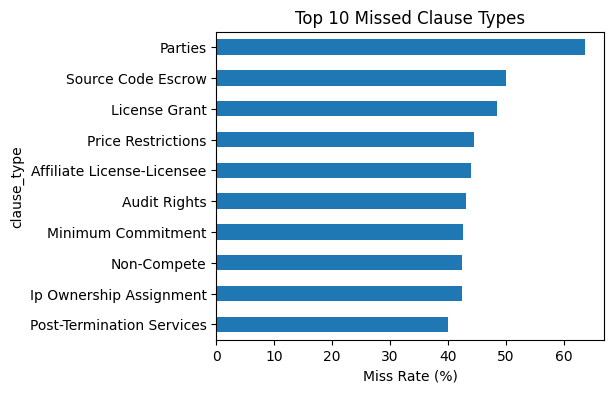

In [73]:
import matplotlib.pyplot as plt

display(clause_summary.head(10))  # View top 10 struggling clauses

# Optional: plot
clause_summary["Miss Rate (%)"].head(10).plot(kind="barh", title="Top 10 Missed Clause Types", figsize=(5,4))
plt.gca().invert_yaxis()
plt.xlabel("Miss Rate (%)")
plt.show()


In [ ]:
#plot well labelled table of bottom 10 clauses and top 10 clauses nxt to each nss
import matplotlib.pyplot as plt
import seaborn as sns
sns.()

,Total,Correct,Missed,Accuracy (%),Miss Rate (%)
clause_type,,,,,
Most Favored Nation,6,5,1,83.333333,16.666667
Renewal Term,56,47,9,83.928571,16.071429
Irrevocable Or Perpetual License,32,27,5,84.375000,15.625000
Joint Ip Ownership,22,19,3,86.363636,13.636364
Expiration Date,130,113,17,86.923077,13.076923
Agreement Date,159,141,18,88.679245,11.320755
Notice Period To Terminate Renewal,36,32,4,88.888889,11.111111
Governing Law,137,122,15,89.051095,10.948905
Document Name,173,164,9,94.797688,5.202312


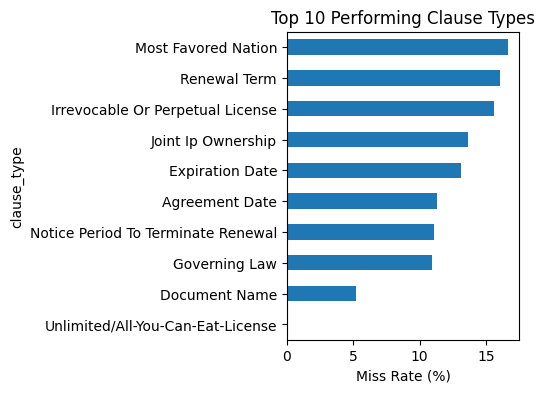

In [74]:
import matplotlib.pyplot as plt

display(clause_summary.tail(10))  # View top 10 struggling clauses

# Optional: plot
clause_summary["Miss Rate (%)"].tail(10).plot(kind="barh", title="Top 10 Performing Clause Types", figsize=(3,4))
plt.gca().invert_yaxis()
plt.xlabel("Miss Rate (%)")
plt.show()


Extract cleaned lists

In [63]:
clean_preds = df_unique["pred"].tolist()
clean_refs = df_unique["ref"].tolist()
clean_doc_ids = df_unique["doc_id"].tolist()
clean_clause_types = df_unique["clause_type"].tolist()


In [65]:
# Option 1
option1_results = document_eval_option_1(clean_preds, clean_refs, clean_doc_ids, clean_clause_types) #(preds, refs, doc_ids, clause_types)
option1_results

{'Approach': 'All Answers Aggregated',
 'Exact Match': np.float64(0.1740976645435244),
 'F1': np.float64(0.7062960167721467),
 'Jaccard': np.float64(0.6449368910228146),
 'BLEU': 0.3780420638723991,
 'ROUGE-1': np.float64(0.7171331088910822),
 'ROUGE-2': np.float64(0.6453074251244566),
 'ROUGE-L': np.float64(0.6165346513195687),
 'Num Docs': 471,
 'Correct Docs': 82,
 'Wrong Docs': 389,
 'Document Accuracy (%)': 17.41,
 'Total Clauses': 2650,
 'Correct Clauses': 1798,
 'Wrong Clauses': 852,
 'Clause Accuracy %': 67.85,
 'doc_breakdown': [{'doc_id': 0,
   'prediction': 'Distributor\nSnotarator LLC\n"Company\nSMSA Ballinger Acquisition Corp. No answer Company hereby appoints Distributor as Company\'s exclusive distributor within the market and grants to Distributor the exclusive right to sell and distribute Products within the Market, and Distributor hereby accepts such appointment and such grant, in accordance with the terms and conditions of this Agreement.',
   'reference': 'No answer

In [66]:
option2_results = document_eval_option_2(clean_preds, clean_refs, clean_doc_ids,clean_clause_types)
#(preds=results["preds"],refs=results["refs"],doc_ids=results["doc_ids"],clause_types=results["clause_types"])
option2_results

{'Approach': 'Best Answer via ROUGE-L',
 'Exact Match': np.float64(0.35881104033970274),
 'F1': np.float64(0.5718082606703121),
 'Jaccard': np.float64(0.5366861669759578),
 'BLEU': 0.2172482011156496,
 'ROUGE-1': np.float64(0.5807469210450492),
 'ROUGE-2': np.float64(0.5216244989402123),
 'ROUGE-L': np.float64(0.5567156485388649),
 'Num Docs': 471,
 'Correct Docs': 169,
 'Wrong Docs': 302,
 'Document Accuracy (%)': 35.88,
 'Total Clauses': 2650,
 'Correct Clauses': 1798,
 'Wrong Clauses': 852,
 'Clause Accuracy %': 67.85,
 'doc_breakdown': [{'doc_id': 0,
   'prediction': 'Distributor\nSnotarator LLC\n"Company\nSMSA Ballinger Acquisition Corp.',
   'reference': 'No answer',
   'exact_match': 0},
  {'doc_id': 1,
   'prediction': 'No answer',
   'reference': 'No answer',
   'exact_match': 1},
  {'doc_id': 2,
   'prediction': 'Within 7 days after the arrival of the goods at destination, should the quality, specification, or quantity be found not in conformity with the stipulations of the C

In [67]:
option3_results = document_eval_option_3(clean_preds, clean_refs, clean_doc_ids,clean_clause_types)
#(results["preds"], results["refs"], results["doc_ids"], results["clause_types"])

option3_results

{'Approach': 'Exact Match → Fallback',
 'Exact Match': np.float64(0.5796178343949044),
 'F1': np.float64(0.6335695924356619),
 'Jaccard': np.float64(0.6253329871429771),
 'BLEU': 0.11341350125318463,
 'ROUGE-1': np.float64(0.6378496263970295),
 'ROUGE-2': np.float64(0.6214405932124918),
 'ROUGE-L': np.float64(0.6344361762840118),
 'Num Docs': 471,
 'Correct Docs': 273,
 'Wrong Docs': 198,
 'Document Accuracy (%)': 57.961783439490446,
 'doc_breakdown': [{'doc_id': 0,
   'prediction': 'No answer',
   'reference': 'Distributor\nElectric City Corp.\nElectric City of Illinois L.L.C.\nCompany\nElectric City of Illinois LLC',
   'exact_match': 0},
  {'doc_id': 1,
   'prediction': 'Distributor\nGoogle\nGoogle Inc\nWhitesmoke Inc.',
   'reference': 'Distributor\nGoogle\nGoogle Inc\nWhitesmoke Inc.',
   'exact_match': 1},
  {'doc_id': 2,
   'prediction': 'Within 7 days after the arrival of the goods at destination, should the quality, specification, or quantity be found not in conformity with th

### Converting tensors doc_id to numbers

In [54]:
for entry in option1_results["doc_breakdown"]:
    if isinstance(entry["doc_id"], torch.Tensor):
        entry["doc_id"] = entry["doc_id"].item()
for entry in option2_results["doc_breakdown"]:
    if isinstance(entry["doc_id"], torch.Tensor):
        entry["doc_id"] = entry["doc_id"].item()

for entry in option3_results["doc_breakdown"]:
    if isinstance(entry["doc_id"], torch.Tensor):
        entry["doc_id"] = entry["doc_id"].item()


def convert_doc_ids_to_int(result_dict):
    for entry in result_dict.get("doc_breakdown", []):
        if isinstance(entry["doc_id"], torch.Tensor):
            entry["doc_id"] = entry["doc_id"].item()

convert_doc_ids_to_int(option1_results)
convert_doc_ids_to_int(option2_results)
convert_doc_ids_to_int(option3_results)

print("Unique documents in Option 1:", len(set([e["doc_id"] for e in option1_results["doc_breakdown"]])))

type(option1_results["doc_breakdown"][0]["doc_id"])

doc_ids = [int(d.item()) if isinstance(d, torch.Tensor) else int(d) for d in doc_ids]
len(doc_ids)

#checking type
type(doc_ids[0])

4928

### unique clauses(chunks) per document

In [59]:
import pandas as pd

df = pd.DataFrame({
    "doc_id": doc_ids,
    "clause_type": clause_types  # or just use "chunk" if clause_type not useful
})

# Count how many clauses per document
clauses_per_doc = df.groupby("doc_id").size().reset_index(name="num_clauses")

# Preview top docs with most clauses
print(clauses_per_doc.sort_values("num_clauses", ascending=False).head())



     doc_id  num_clauses
437     470           73
239     258           66
413     443           65
109     115           65
68       71           56


In [60]:
#clause diversity per document
clause_diversity = df.groupby("doc_id")["clause_type"].nunique().reset_index(name="unique_clause_types")

# Example: most diverse docs
print(clause_diversity.sort_values("unique_clause_types", ascending=False).head())


     doc_id  unique_clause_types
437     470                   25
239     258                   24
388     418                   23
188     199                   22
311     335                   21


In [61]:
doc_summary = df.groupby("doc_id").agg(
    num_clauses=("clause_type", "count"),
    unique_clause_types=("clause_type", pd.Series.nunique)
).reset_index()

print(doc_summary.head())


   doc_id  num_clauses  unique_clause_types
0       0           11                    8
1       1            6                    4
2       2            1                    1
3       3            1                    1
4       5            1                    1


### breakdown of unique clause types

In [ ]:
df_unique["exact_match"] = df_unique.apply(
    lambda row: int(row["pred"].strip().lower() == row["ref"].strip().lower()),
    axis=1
)
